# Graph Embeddings, Node Classification & Link Prediction
### Semester 2 Extension — Massive Graph Management and Analytics

---

**Authors:** Olha Baliasina & Samuel Chapuis

**Datasets:**
- **Amazon Co-Purchasing Network** — 334,863 nodes, 925,872 edges (large-scale)
- **CA-HepTh Collaboration Network** — ~6K–9K authors (small-scale)

**Methods Compared:**
| Category | Methods |
|----------|---------|
| Shallow Embeddings | DeepWalk, Node2Vec (BFS/DFS/Uniform) |
| Spectral | Laplacian Eigenmaps |
| GNNs | GCN, GraphSAGE, GAT |
| Knowledge Graph Emb. | TransE, DistMult |
| Sequential Walk Encoder | GRU-based Walk Encoder |
| Self-Supervised | Deep Graph Infomax (DGI) |
| Ensemble | Concatenation + Weighted Fusion |
| Rule-based | Common Neighbors, Adamic-Adar, Jaccard |

**Tasks:** Node Classification (accuracy, macro-F1) · Link Prediction (AUC, AP, Hits@K, MRR)


---
# Part 0: Setup, Dependencies & Google Drive Checkpointing

We install all dependencies, mount Google Drive for persistent storage, and set up
a checkpoint system so that expensive computations survive Colab disconnections.


In [4]:
# ============================================================
# 0.1  Install dependencies (run once, then restart runtime if needed)
# ============================================================
import subprocess, sys

def pip_install(*packages, **kwargs):
    quiet = kwargs.get('quiet', True)
    cmd = [sys.executable, '-m', 'pip', 'install'] + (['-q'] if quiet else []) + list(packages)
    subprocess.check_call(cmd, stdout=subprocess.DEVNULL if quiet else None)

# Core scientific stack
pip_install('numpy==1.26.4', 'pandas', 'scipy', 'scikit-learn', 'matplotlib', 'seaborn')

# PyTorch + PyG  (adjust cu121/cu124 to match your Colab CUDA)
import torch
cuda_tag = 'cu' + torch.version.cuda.replace('.', '')[:4] if torch.cuda.is_available() else 'cpu'
pip_install(f'torch-geometric')

# Embedding & graph tools
pip_install('gensim', 'umap-learn', 'python-louvain', 'python-igraph', 'tqdm')

print("All dependencies installed.")


All dependencies installed.


In [1]:
# ============================================================
# 0.2  Imports
# ============================================================
import os, sys, time, warnings, pickle, random, gc, json, hashlib
from pathlib import Path
from collections import Counter, defaultdict, deque
from itertools import combinations
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import sparse
from scipy.sparse.linalg import eigsh

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    roc_auc_score, average_precision_score
)
from sklearn.preprocessing import LabelEncoder, StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

# PyTorch Geometric
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
from torch_geometric.utils import negative_sampling, to_undirected

# Gensim for Word2Vec
from gensim.models import Word2Vec

# UMAP
import umap

# Progress bars
from tqdm.auto import tqdm

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
EMB_DIM = 128

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"Device: {DEVICE}")
print(f"PyTorch: {torch.__version__}  |  PyG: {torch_geometric.__version__}")
print(f"CUDA: {torch.version.cuda}" if torch.cuda.is_available() else "CPU mode")


Device: cuda
PyTorch: 2.9.0+cu128  |  PyG: 2.7.0
CUDA: 12.8


In [2]:
# ============================================================
# 0.3  Google Drive Checkpoint System
# ============================================================
# Mount Google Drive for persistent storage across sessions
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
    print("Not in Colab — using local checkpoints.")

# Checkpoint directory
if IN_COLAB:
    CKPT_DIR = Path('/content/drive/MyDrive/MGMA_Part2/checkpoints')
else:
    CKPT_DIR = Path('./checkpoints')

CKPT_DIR.mkdir(parents=True, exist_ok=True)
if IN_COLAB:
    DATA_DIR = Path('/content/drive/MyDrive/MGMA_Part2/data')
else:
    DATA_DIR = Path('./data')
DATA_DIR.mkdir(parents=True, exist_ok=True)

print(f"Checkpoint directory: {CKPT_DIR}")

class CheckpointManager:
    """Save/load experiment artifacts to Google Drive so nothing is lost."""

    def __init__(self, ckpt_dir):
        self.dir = Path(ckpt_dir)
        self.dir.mkdir(parents=True, exist_ok=True)
        self.log_file = self.dir / 'experiment_log.json'
        self.log = self._load_log()

    def _load_log(self):
        if self.log_file.exists():
            with open(self.log_file) as f:
                return json.load(f)
        return {'checkpoints': {}, 'created': str(datetime.now())}

    def _save_log(self):
        with open(self.log_file, 'w') as f:
            json.dump(self.log, f, indent=2, default=str)

    def save(self, name, obj, msg=""):
        path = self.dir / f'{name}.pkl'
        with open(path, 'wb') as f:
            pickle.dump(obj, f)
        self.log['checkpoints'][name] = {
            'time': str(datetime.now()),
            'size_mb': path.stat().st_size / 1e6,
            'msg': msg
        }
        self._save_log()
        print(f"  ✓ Saved: {name} ({path.stat().st_size/1e6:.1f} MB)")

    def load(self, name):
        path = self.dir / f'{name}.pkl'
        if not path.exists():
            return None
        with open(path, 'rb') as f:
            obj = pickle.load(f)
        print(f"  ✓ Loaded: {name} (from checkpoint)")
        return obj

    def exists(self, name):
        return (self.dir / f'{name}.pkl').exists()

    def save_model(self, name, model, optimizer=None, extra=None):
        state = {'model_state': model.state_dict()}
        if optimizer:
            state['optimizer_state'] = optimizer.state_dict()
        if extra:
            state.update(extra)
        self.save(name, state, msg=f"Model: {model.__class__.__name__}")

    def load_model(self, name, model, optimizer=None):
        state = self.load(name)
        if state is None:
            return False
        model.load_state_dict(state['model_state'])
        if optimizer and 'optimizer_state' in state:
            optimizer.load_state_dict(state['optimizer_state'])
        return state

    def status(self):
        if not self.log['checkpoints']:
            print("No checkpoints saved yet.")
            return
        print(f"{'Checkpoint':<40s} {'Size':>8s}  {'Time'}")
        print("-" * 75)
        for name, info in sorted(self.log['checkpoints'].items()):
            print(f"  {name:<38s} {info['size_mb']:>6.1f}MB  {info['time'][:19]}")

ckpt = CheckpointManager(CKPT_DIR)
ckpt.status()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Checkpoint directory: /content/drive/MyDrive/MGMA_Part2/checkpoints
Checkpoint                                   Size  Time
---------------------------------------------------------------------------
  amazon_graph_data                        26.4MB  2026-02-17 04:55:00
  gat_hepth                                 0.2MB  2026-02-17 10:15:08
  gcn_hepth                                 0.1MB  2026-02-17 10:15:06
  gnn_histories_hepth                       0.0MB  2026-02-17 10:15:08
  hepth_graph_data                          1.1MB  2026-02-17 04:55:10
  nc_results_hepth                          0.0MB  2026-02-17 10:15:08
  sage_hepth                                0.2MB  2026-02-17 10:15:06
  shallow_embeddings                      391.3MB  2026-02-17 10:01:58
  spectral_embeddings                      28.0MB  2026-02-17 10:02:14
  structural_features           

---
# Part 1: Data Loading & Preprocessing

We load both datasets, construct node labels, and checkpoint everything.

### Required data files:
- `data/com-amazon.ungraph.txt` — Amazon edge list
- `data/com-amazon.all.dedup.cmty.txt` — Amazon ground-truth communities
- `data/arxiv_hepth_meta.csv` — HepTh paper metadata


## 1.1 Amazon Co-Purchasing Network

The Amazon dataset has overlapping communities — a single node can belong to multiple communities (e.g., a book might be in both "Science Fiction" and "Best Sellers"). But for node classification, we need exactly one label per node.
The naive approach would be to just pick the first community or a random one, but that ignores the graph structure entirely. Instead, we pick the community where the node has the most neighbors also in that community — meaning the community that's most structurally relevant to that node's local neighborhood.
For example, if node A belongs to communities {5, 12, 37}, and 8 of A's neighbors are in community 12 but only 2 are in community 5 and 1 in community 37, we label A as community 12. That's the community where A is most "embedded" structurally, so it gives GNNs and embedding methods the best signal to learn from.

In [3]:
# ============================================================
# 1.1  Load Amazon graph (with checkpoint)
# ============================================================
cached = ckpt.load('amazon_graph_data')
if cached is not None:
    G_amazon = cached['G_amazon']
    labeled_nodes_amazon = cached['labeled_nodes']
    encoded_labels_amazon = cached['encoded_labels']
    amazon_nodes_sorted = cached['nodes_sorted']
    amazon_node_to_idx = cached['node_to_idx']
    TOP_K_AMAZON = cached['top_k']
    print(f"Amazon: {G_amazon.number_of_nodes():,} nodes, {G_amazon.number_of_edges():,} edges")
    print(f"Labeled nodes: {len(labeled_nodes_amazon):,}, Classes: {TOP_K_AMAZON}")
else:
    GRAPH_FILE = DATA_DIR / 'com-amazon.ungraph.txt'
    COMMUNITY_FILE = DATA_DIR / 'com-amazon.all.dedup.cmty.txt'

    print("Loading Amazon co-purchasing network...")
    t0 = time.time()
    G_amazon = nx.read_edgelist(
        str(GRAPH_FILE), comments='#', delimiter='\t',
        create_using=nx.Graph(), nodetype=int
    )
    G_amazon.remove_edges_from(nx.selfloop_edges(G_amazon))
    print(f"Loaded in {time.time()-t0:.1f}s — {G_amazon.number_of_nodes():,} nodes, {G_amazon.number_of_edges():,} edges")

    # Load ground-truth communities
    communities = []
    with open(COMMUNITY_FILE) as f:
        for line in f:
            members = list(map(int, line.strip().split()))
            if len(members) >= 3:
                communities.append(members)
    print(f"Communities loaded: {len(communities):,}")

    # Assign labels: each node → community it shares with most neighbors
    node_to_comms = defaultdict(list)
    for cid, members in enumerate(communities):
        for m in members:
            node_to_comms[m].append(cid)

    node_labels_raw = {}
    for node in tqdm(G_amazon.nodes(), desc="Assigning labels"):
        if node not in node_to_comms:
            continue
        comms = node_to_comms[node]
        if len(comms) == 1:
            node_labels_raw[node] = comms[0]
        else:
            nbrs = set(G_amazon.neighbors(node))
            best_cid, best_overlap = comms[0], 0
            for cid in comms:
                overlap = len(nbrs & set(communities[cid]))
                if overlap > best_overlap:
                    best_overlap = overlap
                    best_cid = cid
            node_labels_raw[node] = best_cid

    # Keep top-K most frequent labels
    TOP_K_AMAZON = 20
    label_counts = Counter(node_labels_raw.values())
    top_labels = set(c for c, _ in label_counts.most_common(TOP_K_AMAZON))

    le = LabelEncoder()
    filtered = [(n, l) for n, l in node_labels_raw.items() if l in top_labels]
    labeled_nodes_amazon = [n for n, _ in filtered]
    raw_labels = [l for _, l in filtered]
    encoded_labels_amazon = le.fit_transform(raw_labels).tolist()

    amazon_nodes_sorted = sorted(G_amazon.nodes())
    amazon_node_to_idx = {n: i for i, n in enumerate(amazon_nodes_sorted)}

    print(f"Labeled nodes: {len(labeled_nodes_amazon):,}, Classes: {TOP_K_AMAZON}")

    # Checkpoint
    ckpt.save('amazon_graph_data', {
        'G_amazon': G_amazon,
        'labeled_nodes': labeled_nodes_amazon,
        'encoded_labels': encoded_labels_amazon,
        'nodes_sorted': amazon_nodes_sorted,
        'node_to_idx': amazon_node_to_idx,
        'top_k': TOP_K_AMAZON,
    }, msg=f"Amazon graph: {G_amazon.number_of_nodes()} nodes")


  ✓ Loaded: amazon_graph_data (from checkpoint)
Amazon: 334,863 nodes, 925,872 edges
Labeled nodes: 173,905, Classes: 20


## 1.2 CA-HepTh Collaboration Network

In [4]:
# ============================================================
# 1.2  Load HepTh graph (with checkpoint)
# ============================================================
cached = ckpt.load('hepth_graph_data')
if cached is not None:
    G_hepth_lcc = cached['G_hepth_lcc']
    labeled_nodes_hepth = cached['labeled_nodes']
    encoded_labels_hepth = cached['encoded_labels']
    hepth_nodes_sorted = cached['nodes_sorted']
    hepth_node_to_idx = cached['node_to_idx']
    print(f"HepTh LCC: {G_hepth_lcc.number_of_nodes():,} nodes, {G_hepth_lcc.number_of_edges():,} edges")
    print(f"Labeled: {len(labeled_nodes_hepth):,}, Classes: {len(set(encoded_labels_hepth))}")
else:
    import ast
    import community.community_louvain as community_louvain

    meta_df = pd.read_csv(str(DATA_DIR / "arxiv_hepth_meta.csv"))

    def safe_parse(x):
        if isinstance(x, list): return x
        try:
            parsed = ast.literal_eval(str(x))
            if isinstance(parsed, list):
                return [str(a).strip() for a in parsed if len(str(a).strip()) > 1]
        except:
            pass
        return []

    meta_df['authors_parsed'] = meta_df['authors_list'].apply(safe_parse)

    # Build co-authorship graph
    G_hepth = nx.Graph()
    for _, row in tqdm(meta_df.iterrows(), total=len(meta_df), desc="Building HepTh graph"):
        authors = row['authors_parsed']
        for a, b in combinations(authors, 2):
            if G_hepth.has_edge(a, b):
                G_hepth[a][b]['weight'] = G_hepth[a][b].get('weight', 1) + 1
            else:
                G_hepth.add_edge(a, b, weight=1)

    # Largest connected component
    lcc_nodes = max(nx.connected_components(G_hepth), key=len)
    G_hepth_lcc = G_hepth.subgraph(lcc_nodes).copy()
    G_hepth_lcc.remove_edges_from(nx.selfloop_edges(G_hepth_lcc))
    print(f"HepTh LCC: {G_hepth_lcc.number_of_nodes():,} nodes, {G_hepth_lcc.number_of_edges():,} edges")

    # Louvain communities as labels
    partition = community_louvain.best_partition(G_hepth_lcc, random_state=SEED)
    comm_sizes = Counter(partition.values())
    MIN_COMM_SIZE = 20
    valid_comms = {c for c, sz in comm_sizes.items() if sz >= MIN_COMM_SIZE}

    le = LabelEncoder()
    labeled_nodes_hepth = [n for n, c in partition.items() if c in valid_comms]
    raw_labels = [partition[n] for n in labeled_nodes_hepth]
    encoded_labels_hepth = le.fit_transform(raw_labels).tolist()

    hepth_nodes_sorted = sorted(G_hepth_lcc.nodes())
    hepth_node_to_idx = {n: i for i, n in enumerate(hepth_nodes_sorted)}

    print(f"Labeled: {len(labeled_nodes_hepth):,}, Classes: {len(set(encoded_labels_hepth))}")

    ckpt.save('hepth_graph_data', {
        'G_hepth_lcc': G_hepth_lcc,
        'labeled_nodes': labeled_nodes_hepth,
        'encoded_labels': encoded_labels_hepth,
        'nodes_sorted': hepth_nodes_sorted,
        'node_to_idx': hepth_node_to_idx,
    }, msg=f"HepTh LCC: {G_hepth_lcc.number_of_nodes()} nodes")


  ✓ Loaded: hepth_graph_data (from checkpoint)
HepTh LCC: 10,397 nodes, 22,231 edges
Labeled: 10,280, Classes: 69


---
# Part 2: Structural Feature Engineering

We compute structural features that serve as node attributes for GNNs
and as a baseline for classification. Features: degree, clustering coefficient,
PageRank, core number.


In [5]:
# ============================================================
# 2.1  Compute structural features (with checkpoint + progress)
# ============================================================
def compute_structural_features(G, name="graph"):
    """Compute structural node features with progress tracking."""
    print(f"Computing structural features for {name}...")
    t0 = time.time()
    G_clean = G.copy()
    G_clean.remove_edges_from(nx.selfloop_edges(G_clean))

    features = {}

    # Degree
    features['degree'] = dict(G_clean.degree())
    print(f"  ✓ Degree ({time.time()-t0:.1f}s)")

    # Clustering coefficient
    features['clustering'] = nx.clustering(G_clean)
    print(f"  ✓ Clustering ({time.time()-t0:.1f}s)")

    # PageRank
    features['pagerank'] = nx.pagerank(G_clean, max_iter=100)
    print(f"  ✓ PageRank ({time.time()-t0:.1f}s)")

    # Core number
    features['core_number'] = nx.core_number(G_clean)
    print(f"  ✓ Core number ({time.time()-t0:.1f}s)")

    print(f"  Done in {time.time()-t0:.1f}s total")
    return features

def build_feature_matrix(G, features, node_list=None):
    """Build normalized feature matrix."""
    if node_list is None:
        node_list = sorted(G.nodes())
    feat_names = ['degree', 'clustering', 'pagerank', 'core_number']
    X = np.zeros((len(node_list), len(feat_names)))
    for j, fname in enumerate(feat_names):
        feat = features[fname]
        for i, node in enumerate(node_list):
            X[i, j] = feat.get(node, 0.0)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X

# --- Compute or load from checkpoint ---
cached = ckpt.load('structural_features')
if cached is not None:
    X_amazon = cached['X_amazon']
    X_hepth = cached['X_hepth']
    print(f"Amazon features: {X_amazon.shape}, HepTh features: {X_hepth.shape}")
else:
    feats_amazon = compute_structural_features(G_amazon, "Amazon")
    X_amazon = build_feature_matrix(G_amazon, feats_amazon, amazon_nodes_sorted)

    feats_hepth = compute_structural_features(G_hepth_lcc, "HepTh")
    X_hepth = build_feature_matrix(G_hepth_lcc, feats_hepth, hepth_nodes_sorted)

    print(f"\nAmazon: {X_amazon.shape}, HepTh: {X_hepth.shape}")

    ckpt.save('structural_features', {
        'X_amazon': X_amazon, 'X_hepth': X_hepth
    }, msg="Structural feature matrices")


  ✓ Loaded: structural_features (from checkpoint)
Amazon features: (334863, 4), HepTh features: (10397, 4)


---
# Part 3: Shallow Embeddings — DeepWalk & Node2Vec

**DeepWalk** performs uniform random walks → Word2Vec Skip-Gram.
**Node2Vec** introduces return parameter *p* and in-out parameter *q* to bias walks:
- Low *q* → BFS-like (local/structural)
- High *q* → DFS-like (global/homophily)


In [6]:
# ============================================================
# 3.1  DeepWalk with progress tracking
# ============================================================
def deepwalk(G, dimensions=128, walk_length=40, num_walks=10,
             window=5, workers=2, seed=42):
    """DeepWalk: uniform random walks + Word2Vec Skip-Gram."""
    rng = random.Random(seed)
    nodes = list(G.nodes())

    walks = []
    for _ in tqdm(range(num_walks), desc="DeepWalk walks"):
        rng.shuffle(nodes)
        for v in nodes:
            walk = [v]
            for _ in range(walk_length - 1):
                cur = walk[-1]
                nbrs = list(G.neighbors(cur))
                if not nbrs:
                    break
                walk.append(rng.choice(nbrs))
            walks.append([str(x) for x in walk])

    print(f"  Training Word2Vec on {len(walks):,} walks...")
    model = Word2Vec(
        sentences=walks, vector_size=dimensions, window=window,
        min_count=0, sg=1, workers=workers, seed=seed, epochs=5
    )
    emb = {}
    for k in model.wv.index_to_key:
        try:
            emb[int(k)] = model.wv[k]
        except ValueError:
            emb[k] = model.wv[k]
    return emb, model


In [7]:
# ============================================================
# 3.2  Node2Vec with biased walks + progress
# ============================================================
def node2vec_embed(G, dimensions=128, walk_length=40, num_walks=10,
                   p=1.0, q=1.0, window=5, workers=2, seed=42):
    """Node2Vec with biased random walks (p=return, q=in-out)."""

    # Precompute transition probabilities
    alias_nodes = {}
    alias_edges = {}

    def compute_alias(probs):
        K = len(probs)
        q_arr = np.zeros(K)
        smaller, larger = [], []
        for i, p in enumerate(probs):
            q_arr[i] = K * p
            if q_arr[i] < 1.0:
                smaller.append(i)
            else:
                larger.append(i)
        J = np.zeros(K, dtype=int)
        while smaller and larger:
            s, l = smaller.pop(), larger.pop()
            J[s] = l
            q_arr[l] -= (1.0 - q_arr[s])
            if q_arr[l] < 1.0:
                smaller.append(l)
            else:
                larger.append(l)
        return J, q_arr

    def alias_sample(J, q_arr):
        K = len(J)
        k = int(np.floor(np.random.rand() * K))
        if np.random.rand() < q_arr[k]:
            return k
        return J[k]

    print("  Precomputing transition probabilities...")
    for node in G.nodes():
        nbrs = sorted(G.neighbors(node))
        if not nbrs:
            continue
        probs = np.array([G[node][nbr].get('weight', 1.0) for nbr in nbrs], dtype=float)
        probs /= probs.sum()
        alias_nodes[node] = (nbrs, compute_alias(probs))

    for edge in tqdm(list(G.edges()), desc="  Edge probs"):
        for src, dst in [(edge[0], edge[1]), (edge[1], edge[0])]:
            nbrs = sorted(G.neighbors(dst))
            if not nbrs:
                continue
            probs = []
            for nbr in nbrs:
                w = G[dst][nbr].get('weight', 1.0)
                if nbr == src:
                    probs.append(w / p)  # return
                elif G.has_edge(nbr, src):
                    probs.append(w)       # BFS
                else:
                    probs.append(w / q)   # DFS
            probs = np.array(probs, dtype=float)
            probs /= probs.sum()
            alias_edges[(src, dst)] = (nbrs, compute_alias(probs))

    # Generate walks
    np.random.seed(seed)
    nodes = list(G.nodes())
    walks = []
    for _ in tqdm(range(num_walks), desc=f"  Node2Vec(p={p},q={q})"):
        np.random.shuffle(nodes)
        for start in nodes:
            walk = [start]
            if start not in alias_nodes:
                walks.append([str(x) for x in walk])
                continue
            nbrs, (J, q_arr) = alias_nodes[start]
            walk.append(nbrs[alias_sample(J, q_arr)])
            for _ in range(walk_length - 2):
                cur = walk[-1]
                prev = walk[-2]
                key = (prev, cur)
                if key in alias_edges:
                    nbrs_e, (Je, qe) = alias_edges[key]
                    walk.append(nbrs_e[alias_sample(Je, qe)])
                elif cur in alias_nodes:
                    nbrs_n, (Jn, qn) = alias_nodes[cur]
                    walk.append(nbrs_n[alias_sample(Jn, qn)])
                else:
                    break
            walks.append([str(x) for x in walk])

    print(f"  Training Word2Vec on {len(walks):,} walks...")
    model = Word2Vec(
        sentences=walks, vector_size=dimensions, window=window,
        min_count=0, sg=1, workers=workers, seed=seed, epochs=5
    )
    emb = {}
    for k in model.wv.index_to_key:
        try:
            emb[int(k)] = model.wv[k]
        except ValueError:
            emb[k] = model.wv[k]
    return emb, model


In [8]:
# ============================================================
# 3.3  Run Shallow Embeddings on both datasets
# ============================================================
cached = ckpt.load('shallow_embeddings')
if cached is not None:
    amazon_dw_emb = cached['amazon_dw']
    hepth_dw_emb = cached['hepth_dw']
    hepth_n2v_bfs = cached['hepth_n2v_bfs']
    hepth_n2v_uni = cached['hepth_n2v_uni']
    hepth_n2v_dfs = cached['hepth_n2v_dfs']
    amazon_n2v_bfs = cached['amazon_n2v_bfs']
    print("All shallow embeddings loaded from checkpoint.")
else:
    print("=" * 60)
    print("AMAZON — DeepWalk")
    print("=" * 60)
    amazon_dw_emb, _ = deepwalk(G_amazon, dimensions=EMB_DIM, walk_length=40, num_walks=10)

    print("\n" + "=" * 60)
    print("AMAZON — Node2Vec (BFS: p=1, q=0.5)")
    print("=" * 60)
    amazon_n2v_bfs, _ = node2vec_embed(G_amazon, dimensions=EMB_DIM, walk_length=40,
                                        num_walks=10, p=1.0, q=0.5)

    print("\n" + "=" * 60)
    print("HEPTH — DeepWalk")
    print("=" * 60)
    hepth_dw_emb, _ = deepwalk(G_hepth_lcc, dimensions=EMB_DIM, walk_length=40, num_walks=10)

    print("\n" + "=" * 60)
    print("HEPTH — Node2Vec (3 configs)")
    print("=" * 60)
    hepth_n2v_bfs, _ = node2vec_embed(G_hepth_lcc, dimensions=EMB_DIM, walk_length=40,
                                       num_walks=10, p=1.0, q=0.5)
    hepth_n2v_uni, _ = node2vec_embed(G_hepth_lcc, dimensions=EMB_DIM, walk_length=40,
                                       num_walks=10, p=1.0, q=1.0)
    hepth_n2v_dfs, _ = node2vec_embed(G_hepth_lcc, dimensions=EMB_DIM, walk_length=40,
                                       num_walks=10, p=1.0, q=2.0)

    print("\nSaving shallow embeddings...")
    ckpt.save('shallow_embeddings', {
        'amazon_dw': amazon_dw_emb,
        'hepth_dw': hepth_dw_emb,
        'hepth_n2v_bfs': hepth_n2v_bfs,
        'hepth_n2v_uni': hepth_n2v_uni,
        'hepth_n2v_dfs': hepth_n2v_dfs,
        'amazon_n2v_bfs': amazon_n2v_bfs,
    }, msg="All shallow embeddings (DeepWalk + Node2Vec)")


  ✓ Loaded: shallow_embeddings (from checkpoint)
All shallow embeddings loaded from checkpoint.


---
# Part 4: Spectral Embeddings — Laplacian Eigenmaps

Compute the *k* smallest non-trivial eigenvectors of the normalized graph Laplacian
$L_{norm} = D^{-1/2}(D - A)D^{-1/2}$. The spectral gap (λ₂ - λ₁) indicates community structure strength.


In [ ]:
# ============================================================
# 4.1  Laplacian Eigenmaps
# ============================================================
def laplacian_eigenmaps(G, dimensions=128, normalized=True):
    """
    Compute Laplacian Eigenmaps embedding.
    Strategy:
      1. Small graphs (<50K): eigsh on (I-L), fast and exact
      2. Large graphs: LOBPCG with progress output
      3. Fallback: randomized SVD
    """
    from sklearn.utils.extmath import randomized_svd
    from scipy.sparse.linalg import lobpcg

    n = G.number_of_nodes()
    print(f"Laplacian Eigenmaps: {n:,} nodes, dim={dimensions}, normalized={normalized}")

    nodes = sorted(G.nodes())
    A = nx.adjacency_matrix(G, nodelist=nodes).astype(float)
    deg = np.array(A.sum(axis=1)).flatten()

    if normalized:
        D_inv_sqrt = sparse.diags(1.0 / np.sqrt(np.maximum(deg, 1e-10)))
        L = sparse.eye(n) - D_inv_sqrt @ A @ D_inv_sqrt
    else:
        L = sparse.diags(deg) - A

    I_minus_L = sparse.eye(n) - L
    k = min(dimensions + 1, n - 1)
    eigenvectors = None

    if n < 50000:
        # --- Small graph: eigsh (fast, exact, no progress needed) ---
        print(f"  [eigsh] Computing largest eigenvectors of (I - L)...")
        t0 = time.time()
        try:
            eigenvalues, eigenvectors = eigsh(I_minus_L, k=k, which='LM', tol=1e-4)
            eigenvalues = 1.0 - eigenvalues
            print(f"  ✓ Done in {time.time()-t0:.1f}s (exact)")
        except Exception as e:
            print(f"  ✗ eigsh failed: {e}")
            eigenvectors = None
    else:
        # --- Large graph: LOBPCG (exact, shows convergence progress) ---
        print(f"  [LOBPCG] Iterative solver with progress...")
        t0 = time.time()
        try:
            X0 = np.random.RandomState(42).randn(n, k).astype(np.float64)
            eigenvalues, eigenvectors = lobpcg(
                L, X0, largest=False, maxiter=500, tol=1e-4, verbosityLevel=1
            )
            print(f"  ✓ Done in {time.time()-t0:.1f}s (exact)")
        except Exception as e:
            print(f"  ✗ LOBPCG failed: {e}")
            eigenvectors = None

    # --- Fallback: randomized SVD ---
    if eigenvectors is None:
        print(f"  [Fallback] Randomized SVD...")
        t0 = time.time()
        U, S, Vt = randomized_svd(I_minus_L, n_components=k, random_state=42)
        eigenvalues = 1.0 - S
        eigenvectors = U
        print(f"  ✓ Done in {time.time()-t0:.1f}s (approximate)")

    # Sort and skip trivial eigenvalue
    idx = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    emb = eigenvectors[:, 1:dimensions+1]
    embeddings = {nodes[i]: emb[i] for i in range(n)}
    print(f"  Spectral gap: {eigenvalues[1]:.6f}")
    return embeddings, eigenvalues

# Run spectral embeddings
cached = ckpt.load('spectral_embeddings')
if cached is not None:
    hepth_spectral_emb = cached['hepth_spectral']
    hepth_eigenvalues = cached['hepth_eigenvalues']
    amazon_spectral_emb = cached.get('amazon_spectral')
    amazon_eigenvalues = cached.get('amazon_eigenvalues')
    G_amazon_sub = cached.get('G_amazon_sub')
    print("Spectral embeddings loaded from checkpoint.")
else:
    # HepTh (full LCC)
    print("=" * 60)
    print("HEPTH — Laplacian Eigenmaps (full LCC)")
    print("=" * 60)
    hepth_spectral_emb, hepth_eigenvalues = laplacian_eigenmaps(
        G_hepth_lcc, dimensions=EMB_DIM, normalized=True
    )

    # Amazon
    print("\n" + "=" * 60)
    print("AMAZON — Laplacian Eigenmaps (FULL graph, 335K nodes)")
    print("=" * 60)

    amazon_spectral_emb, amazon_eigenvalues = laplacian_eigenmaps(
        G_amazon, dimensions=EMB_DIM, normalized=True
    )

    ckpt.save('spectral_embeddings', {
        'hepth_spectral': hepth_spectral_emb,
        'hepth_eigenvalues': hepth_eigenvalues,
        'amazon_spectral': amazon_spectral_emb,
        'amazon_eigenvalues': amazon_eigenvalues,
    }, msg="Spectral embeddings + eigenvalues")


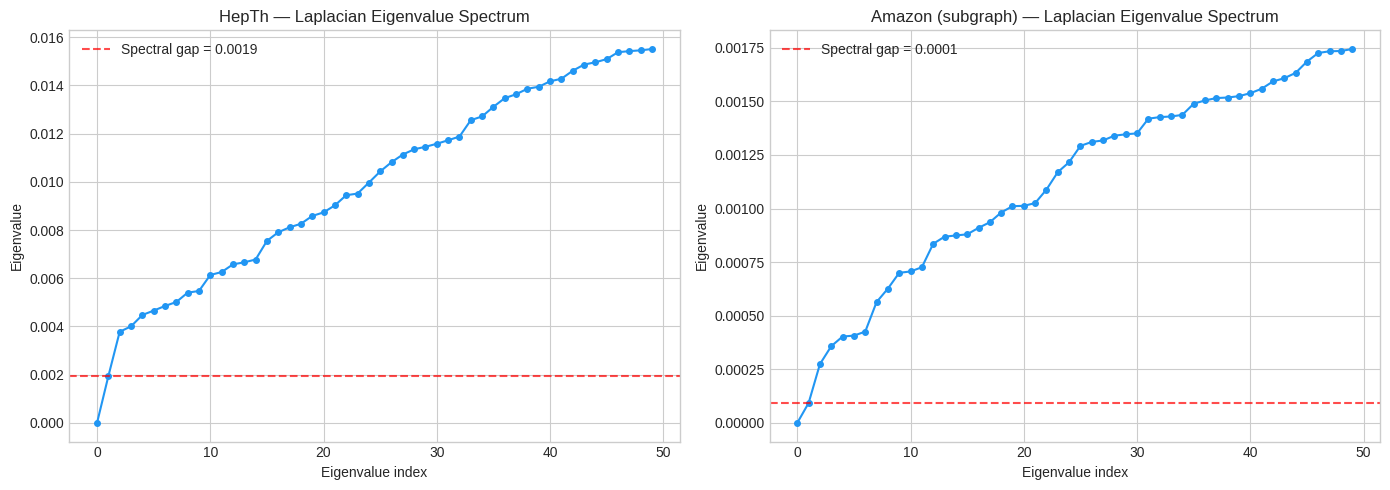

In [11]:
# ============================================================
# 4.2  Eigenvalue spectrum visualization
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, evals, name in [
    (axes[0], hepth_eigenvalues, "HepTh"),
    (axes[1], amazon_eigenvalues, "Amazon (subgraph)")
]:
    ax.plot(evals[:50], 'o-', markersize=4, color='#2196F3')
    ax.axhline(y=evals[1], color='red', linestyle='--', alpha=0.7,
               label=f'Spectral gap = {evals[1]:.4f}')
    ax.set_xlabel('Eigenvalue index')
    ax.set_ylabel('Eigenvalue')
    ax.set_title(f'{name} — Laplacian Eigenvalue Spectrum')
    ax.legend()

plt.tight_layout()
plt.savefig('eigenvalue_spectrum.png', dpi=150, bbox_inches='tight')
plt.show()


---
# Part 5: Graph Neural Networks — GCN, GraphSAGE, GAT

All GNNs follow the **message-passing** paradigm. We implement three standard architectures
with proper training utilities including progress bars, early stopping, and learning rate scheduling.


In [12]:
# ============================================================
# 5.1  GNN Model Definitions
# ============================================================
class GCN(nn.Module):
    def __init__(self, in_ch, hid_ch, out_ch, num_layers=2, dropout=0.5):
        super().__init__()
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        self.convs.append(GCNConv(in_ch, hid_ch))
        self.bns.append(nn.BatchNorm1d(hid_ch))
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hid_ch, hid_ch))
            self.bns.append(nn.BatchNorm1d(hid_ch))
        self.convs.append(GCNConv(hid_ch, out_ch))
        self.dropout = dropout

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        return self.convs[-1](x, edge_index)

    def get_embedding(self, x, edge_index):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            x = self.bns[i](x)
            x = F.relu(x)
        return x


class GraphSAGE(nn.Module):
    def __init__(self, in_ch, hid_ch, out_ch, num_layers=2, dropout=0.5):
        super().__init__()
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        self.convs.append(SAGEConv(in_ch, hid_ch))
        self.bns.append(nn.BatchNorm1d(hid_ch))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hid_ch, hid_ch))
            self.bns.append(nn.BatchNorm1d(hid_ch))
        self.convs.append(SAGEConv(hid_ch, out_ch))
        self.dropout = dropout

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        return self.convs[-1](x, edge_index)

    def get_embedding(self, x, edge_index):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            x = self.bns[i](x)
            x = F.relu(x)
        return x


class GAT(nn.Module):
    def __init__(self, in_ch, hid_ch, out_ch, num_layers=2, heads=4, dropout=0.5):
        super().__init__()
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        self.convs.append(GATConv(in_ch, hid_ch, heads=heads, dropout=dropout))
        self.bns.append(nn.BatchNorm1d(hid_ch * heads))
        for _ in range(num_layers - 2):
            self.convs.append(GATConv(hid_ch * heads, hid_ch, heads=heads, dropout=dropout))
            self.bns.append(nn.BatchNorm1d(hid_ch * heads))
        self.convs.append(GATConv(hid_ch * heads, out_ch, heads=1, concat=False, dropout=dropout))
        self.dropout = dropout

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            x = self.bns[i](x)
            x = F.elu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        return self.convs[-1](x, edge_index)

    def get_embedding(self, x, edge_index):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            x = self.bns[i](x)
            x = F.elu(x)
        return x


In [30]:
# ============================================================
# 5.2  Training utilities with progress bars + LR scheduling
# ============================================================
def train_gnn_epoch(model, data, optimizer, criterion, mask):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[mask], data.y[mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def eval_gnn(model, data, mask):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out[mask].argmax(dim=1)
    y_true = data.y[mask].cpu().numpy()
    y_pred = pred.cpu().numpy()
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
        'f1_micro': f1_score(y_true, y_pred, average='micro', zero_division=0),
    }

def train_gnn_full(model, data, epochs=300, lr=0.01, weight_decay=5e-4,
                   patience=30, name="GNN", ckpt_name=None):
    """Full GNN training with progress bar, early stopping, LR scheduling, and checkpointing."""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10)

    # Class-weighted loss — helps F1-macro on imbalanced classes
    from sklearn.utils.class_weight import compute_class_weight
    train_labels = data.y[data.train_mask].cpu().numpy()
    weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    class_weights = torch.tensor(weights, dtype=torch.float).to(data.x.device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    best_val_f1 = 0
    best_state = None
    patience_counter = 0
    history = {'train_loss': [], 'val_acc': [], 'val_f1': []}

    pbar = tqdm(range(1, epochs + 1), desc=f"Training {name}", leave=True)
    for epoch in pbar:
        loss = train_gnn_epoch(model, data, optimizer, criterion, data.train_mask)
        val_metrics = eval_gnn(model, data, data.val_mask)
        scheduler.step(val_metrics['f1_macro'])

        history['train_loss'].append(loss)
        history['val_acc'].append(val_metrics['accuracy'])
        history['val_f1'].append(val_metrics['f1_macro'])

        pbar.set_postfix({
            'loss': f"{loss:.4f}",
            'val_F1': f"{val_metrics['f1_macro']:.4f}",
            'lr': f"{optimizer.param_groups[0]['lr']:.1e}"
        })

        if val_metrics['f1_macro'] > best_val_f1:
            best_val_f1 = val_metrics['f1_macro']
            best_state = {k: v.clone() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                pbar.set_description(f"{name} (early stop @ {epoch})")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    test_metrics = eval_gnn(model, data, data.test_mask)
    print(f"  {name} test: acc={test_metrics['accuracy']:.4f}, F1={test_metrics['f1_macro']:.4f}")

    if ckpt_name:
        ckpt.save_model(ckpt_name, model, extra={'history': history, 'test_metrics': test_metrics})

    return model, history, test_metrics


In [31]:
# Build enriched features: structural (4d) + DeepWalk embedding (128d) = 132d

def build_enriched_features(X_struct, emb_dict_list, nodes_sorted, node_to_idx, emb_dim=128):
    """Concatenate structural features with multiple embedding sets."""
    n = len(nodes_sorted)
    all_features = [X_struct]
    for emb_dict in emb_dict_list:
        X_emb = np.zeros((n, emb_dim))
        for node in nodes_sorted:
            if node in emb_dict:
                X_emb[node_to_idx[node]] = emb_dict[node]
        all_features.append(StandardScaler().fit_transform(X_emb))
    X_enriched = np.concatenate(all_features, axis=1)
    print(f"  Enriched: {X_struct.shape[1]} structural + {len(emb_dict_list)}×{emb_dim} embedding = {X_enriched.shape[1]}d")
    return X_enriched

X_hepth_rich = build_enriched_features(
    X_hepth, [hepth_dw_emb, hepth_n2v_bfs],
    hepth_nodes_sorted, hepth_node_to_idx
)
X_amazon_rich = build_enriched_features(
    X_amazon, [amazon_dw_emb, amazon_n2v_bfs],
    amazon_nodes_sorted, amazon_node_to_idx
)




# def build_enriched_features(X_struct, emb_dict, nodes_sorted, node_to_idx, emb_dim=128):
#     """Concatenate structural features with pre-trained embeddings."""
#     n = len(nodes_sorted)
#     X_emb = np.zeros((n, emb_dim))
#     for node in nodes_sorted:
#         if node in emb_dict:
#             X_emb[node_to_idx[node]] = emb_dict[node]
#     scaler = StandardScaler()
#     X_emb = scaler.fit_transform(X_emb)
#     X_enriched = np.concatenate([X_struct, X_emb], axis=1)
#     print(f"  Enriched: {X_struct.shape[1]} structural + {emb_dim} embedding = {X_enriched.shape[1]}d")
#     return X_enriched

# print("Building enriched features (structural + DeepWalk)...")
# X_hepth_rich = build_enriched_features(X_hepth, hepth_dw_emb, hepth_nodes_sorted, hepth_node_to_idx)
# X_amazon_rich = build_enriched_features(X_amazon, amazon_dw_emb, amazon_nodes_sorted, amazon_node_to_idx)

  Enriched: 4 structural + 2×128 embedding = 260d
  Enriched: 4 structural + 2×128 embedding = 260d


In [32]:
# ============================================================
# 5.3  Prepare PyG Data objects
# ============================================================
def prepare_pyg_data(G, X_features, labeled_nodes, encoded_labels,
                     node_to_idx, train_ratio=0.6, val_ratio=0.2, seed=42):
    """Convert NetworkX graph → PyG Data with stratified masks."""
    nodes_sorted = sorted(G.nodes())
    n = len(nodes_sorted)

    edges = list(G.edges())
    src = [node_to_idx[u] for u, v in edges]
    dst = [node_to_idx[v] for u, v in edges]
    edge_index = torch.tensor([src + dst, dst + src], dtype=torch.long)

    x = torch.tensor(X_features, dtype=torch.float)

    y = torch.full((n,), -1, dtype=torch.long)
    labeled_indices = [node_to_idx[node] for node in labeled_nodes]
    for idx, label in zip(labeled_indices, encoded_labels):
        y[idx] = label

    labeled_indices = np.array(labeled_indices)
    idx_train, idx_temp, y_train, y_temp = train_test_split(
        labeled_indices, encoded_labels,
        train_size=train_ratio, stratify=encoded_labels, random_state=seed
    )
    val_frac = val_ratio / (1 - train_ratio)
    idx_val, idx_test, _, _ = train_test_split(
        idx_temp, y_temp,
        train_size=val_frac, stratify=y_temp, random_state=seed
    )

    train_mask = torch.zeros(n, dtype=torch.bool); train_mask[idx_train] = True
    val_mask = torch.zeros(n, dtype=torch.bool); val_mask[idx_val] = True
    test_mask = torch.zeros(n, dtype=torch.bool); test_mask[idx_test] = True

    data = Data(x=x, edge_index=edge_index, y=y,
                train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
    print(f"PyG Data: {data}")
    print(f"  Train: {train_mask.sum().item():,}  Val: {val_mask.sum().item():,}  Test: {test_mask.sum().item():,}")
    return data

# Build PyG data objects
data_hepth = prepare_pyg_data(
    G_hepth_lcc, X_hepth_rich, labeled_nodes_hepth, encoded_labels_hepth, hepth_node_to_idx
).to(DEVICE)

data_amazon = prepare_pyg_data(
    G_amazon, X_amazon_rich, labeled_nodes_amazon, encoded_labels_amazon, amazon_node_to_idx
).to(DEVICE)


PyG Data: Data(x=[10397, 260], edge_index=[2, 44462], y=[10397], train_mask=[10397], val_mask=[10397], test_mask=[10397])
  Train: 6,168  Val: 2,056  Test: 2,056
PyG Data: Data(x=[334863, 260], edge_index=[2, 1851744], y=[334863], train_mask=[334863], val_mask=[334863], test_mask=[334863])
  Train: 104,343  Val: 34,781  Test: 34,781


In [16]:
# import os
# for name in ['nc_results_hepth', 'gnn_histories_hepth', 'gcn_hepth', 'sage_hepth', 'gat_hepth']:
#     path = CKPT_DIR / f'{name}.pkl'
#     if path.exists():
#         os.remove(path)
#         print(f"Deleted: {name}")

---
# Part 6: Node Classification Experiments

**Protocol:**
1. Shallow & Spectral embeddings → Logistic Regression (+ Random Forest)
2. GNNs → end-to-end supervised training


In [33]:
# ============================================================
# 6.1  Embedding evaluation utilities
# ============================================================
def evaluate_embedding_classification(embeddings, labeled_nodes, encoded_labels,
                                      name="Embedding", test_size=0.2, val_size=0.2):
    """Evaluate embeddings via Logistic Regression + Random Forest."""
    valid = [(n, l) for n, l in zip(labeled_nodes, encoded_labels) if n in embeddings]
    if len(valid) == 0:
        print(f"  {name}: No valid nodes!")
        return None

    nodes, labels = zip(*valid)
    X = np.array([embeddings[n] for n in nodes])
    y = np.array(labels)

    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=(test_size + val_size), stratify=y, random_state=SEED
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=test_size/(test_size+val_size),
        stratify=y_temp, random_state=SEED
    )

    # Logistic Regression
    lr = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial', random_state=SEED)
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)

    results = {
        'accuracy': accuracy_score(y_test, y_pred_lr),
        'f1_macro': f1_score(y_test, y_pred_lr, average='macro', zero_division=0),
        'f1_micro': f1_score(y_test, y_pred_lr, average='micro', zero_division=0),
        'n_test': len(y_test),
    }
    print(f"  {name}: acc={results['accuracy']:.4f}, F1-macro={results['f1_macro']:.4f}")
    return results


In [37]:
# ============================================================
# 6.2  Node Classification — HepTh (all methods)
# ============================================================
cached = ckpt.load('nc_results_hepth')
if cached is not None:
    hepth_nc_results = cached
    print("HepTh NC results loaded from checkpoint.")
    for m, r in hepth_nc_results.items():
        if r: print(f"  {m}: acc={r['accuracy']:.4f}, F1={r['f1_macro']:.4f}")
else:
    print("=" * 70)
    print("NODE CLASSIFICATION — HepTh")
    print("=" * 70)
    hepth_nc_results = {}

    # Structural baseline
    struct_emb = {n: X_hepth[hepth_node_to_idx[n]] for n in hepth_nodes_sorted}
    hepth_nc_results['Structural'] = evaluate_embedding_classification(
        struct_emb, labeled_nodes_hepth, encoded_labels_hepth, "Structural"
    )

    # Shallow embeddings
    for name, emb in [('DeepWalk', hepth_dw_emb),
                       ('Node2Vec-BFS', hepth_n2v_bfs),
                       ('Node2Vec-Uni', hepth_n2v_uni),
                       ('Node2Vec-DFS', hepth_n2v_dfs)]:
        hepth_nc_results[name] = evaluate_embedding_classification(
            emb, labeled_nodes_hepth, encoded_labels_hepth, name
        )

    # Spectral
    hepth_nc_results['Spectral'] = evaluate_embedding_classification(
        hepth_spectral_emb, labeled_nodes_hepth, encoded_labels_hepth, "Spectral"
    )

    # GNNs
    n_classes = len(set(encoded_labels_hepth))
    in_ch = data_hepth.x.shape[1]

    print("\n--- GCN ---")
    gcn = GCN(in_ch, 128, n_classes, num_layers=2, dropout=0.5).to(DEVICE)
    gcn, hist_gcn, test_gcn = train_gnn_full(gcn, data_hepth, epochs=300, patience=30,
                                              name="GCN", ckpt_name="gcn_hepth")
    hepth_nc_results['GCN'] = test_gcn

    print("\n--- GraphSAGE ---")
    sage = GraphSAGE(in_ch, 128, n_classes, num_layers=2, dropout=0.5).to(DEVICE)
    sage, hist_sage, test_sage = train_gnn_full(sage, data_hepth, epochs=300, patience=30,
                                                 name="GraphSAGE", ckpt_name="sage_hepth")
    hepth_nc_results['GraphSAGE'] = test_sage

    print("\n--- GAT ---")
    gat = GAT(in_ch, 64, n_classes, num_layers=2, heads=4, dropout=0.5).to(DEVICE)
    gat, hist_gat, test_gat = train_gnn_full(gat, data_hepth, epochs=300, patience=30,
                                              name="GAT", ckpt_name="gat_hepth")
    hepth_nc_results['GAT'] = test_gat

    # Store training histories for later plotting
    gnn_histories_hepth = {'GCN': hist_gcn, 'GraphSAGE': hist_sage, 'GAT': hist_gat}
    ckpt.save('gnn_histories_hepth', gnn_histories_hepth)
    ckpt.save('nc_results_hepth', hepth_nc_results, msg="HepTh node classification results")


NODE CLASSIFICATION — HepTh
  Structural: acc=0.0773, F1-macro=0.0037
  DeepWalk: acc=0.9518, F1-macro=0.9583
  Node2Vec-BFS: acc=0.9591, F1-macro=0.9658
  Node2Vec-Uni: acc=0.9557, F1-macro=0.9637
  Node2Vec-DFS: acc=0.9591, F1-macro=0.9627
  Spectral: acc=0.0807, F1-macro=0.0059

--- GCN ---


Training GCN:   0%|          | 0/300 [00:00<?, ?it/s]

  GCN test: acc=0.9684, F1=0.9731
  ✓ Saved: gcn_hepth (0.2 MB)

--- GraphSAGE ---


Training GraphSAGE:   0%|          | 0/300 [00:00<?, ?it/s]

  GraphSAGE test: acc=0.9742, F1=0.9773
  ✓ Saved: sage_hepth (0.3 MB)

--- GAT ---


Training GAT:   0%|          | 0/300 [00:00<?, ?it/s]

  GAT test: acc=0.9655, F1=0.9726
  ✓ Saved: gat_hepth (0.4 MB)
  ✓ Saved: gnn_histories_hepth (0.0 MB)
  ✓ Saved: nc_results_hepth (0.0 MB)


In [20]:
import torch
print(torch.__version__)
print(torch.version.cuda)

2.9.0+cu128
12.8


In [21]:
# !pip install -q torch-sparse torch-scatter \
#   -f https://data.pyg.org/whl/torch-2.9.0+cu124.html

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [19]:
# import torch
# !pip install -q pyg-lib torch-sparse torch-scatter \
#   -f https://data.pyg.org/whl/torch-{torch.__version__}+cu121.html

ERROR: Could not find a version that satisfies the requirement pyg-lib (from versions: none)
ERROR: No matching distribution found for pyg-lib


In [36]:
# import os
# for name in ['nc_results_hepth', 'nc_results_amazon', 'gnn_histories_hepth',
#              'gcn_hepth', 'sage_hepth', 'gat_hepth',
#              'gcn_amazon', 'sage_amazon', 'gat_amazon']:
#     path = CKPT_DIR / f'{name}.pkl'
#     if path.exists():
#         os.remove(path)
#         print(f"Deleted: {name}")

Deleted: nc_results_hepth
Deleted: gnn_histories_hepth
Deleted: gcn_hepth
Deleted: sage_hepth
Deleted: gat_hepth
Deleted: gcn_amazon
Deleted: sage_amazon
Deleted: gat_amazon


In [38]:
# ============================================================
# 6.3  Node Classification — Amazon (scalable methods)
# ============================================================
cached = ckpt.load('nc_results_amazon')
if cached is not None:
    amazon_nc_results = cached
    print("Amazon NC results loaded from checkpoint.")
    for m, r in amazon_nc_results.items():
        if r: print(f"  {m}: acc={r['accuracy']:.4f}, F1={r['f1_macro']:.4f}")
else:
    print("=" * 70)
    print("NODE CLASSIFICATION — Amazon")
    print("=" * 70)
    amazon_nc_results = {}

    # Structural baseline
    struct_emb = {n: X_amazon[amazon_node_to_idx[n]] for n in amazon_nodes_sorted}
    amazon_nc_results['Structural'] = evaluate_embedding_classification(
        struct_emb, labeled_nodes_amazon, encoded_labels_amazon, "Structural"
    )

    # Shallow
    for name, emb in [('DeepWalk', amazon_dw_emb), ('Node2Vec-BFS', amazon_n2v_bfs)]:
        amazon_nc_results[name] = evaluate_embedding_classification(
            emb, labeled_nodes_amazon, encoded_labels_amazon, name
        )

    # Spectral
    if amazon_spectral_emb is not None:
        amazon_nc_results['Spectral'] = evaluate_embedding_classification(
            amazon_spectral_emb, labeled_nodes_amazon, encoded_labels_amazon, "Spectral"
        )

    # Full-batch GNNs (same approach as HepTh — no torch-sparse needed)
    n_classes = len(set(encoded_labels_amazon))
    in_ch = data_amazon.x.shape[1]

    print("\n--- GraphSAGE (full-batch, full graph) ---")
    sage_amz = GraphSAGE(in_ch, 128, n_classes, num_layers=2, dropout=0.5).to(DEVICE)
    sage_amz, hist_sage_amz, test_sage_amz = train_gnn_full(
        sage_amz, data_amazon, epochs=400, patience=30,
        name="GraphSAGE Amazon", ckpt_name="sage_amazon"
    )
    amazon_nc_results['GraphSAGE'] = test_sage_amz

    print("\n--- GCN (full-batch, full graph) ---")
    gcn_amz = GCN(in_ch, 128, n_classes, num_layers=2, dropout=0.5).to(DEVICE)
    gcn_amz, hist_gcn_amz, test_gcn_amz = train_gnn_full(
        gcn_amz, data_amazon, epochs=400, patience=30,
        name="GCN Amazon", ckpt_name="gcn_amazon"
    )
    amazon_nc_results['GCN'] = test_gcn_amz

    print("\n--- GAT (full-batch, full graph) ---")
    gat_amz = GAT(in_ch, 64, n_classes, num_layers=2, heads=4, dropout=0.5).to(DEVICE)
    gat_amz, hist_gat_amz, test_gat_amz = train_gnn_full(
        gat_amz, data_amazon, epochs=400, patience=30,
        name="GAT Amazon", ckpt_name="gat_amazon"
    )
    amazon_nc_results['GAT'] = test_gat_amz


    ckpt.save('nc_results_amazon', amazon_nc_results, msg="Amazon node classification results")

NODE CLASSIFICATION — Amazon
  Structural: acc=0.1512, F1-macro=0.0454
  DeepWalk: acc=0.7366, F1-macro=0.6658
  Node2Vec-BFS: acc=0.7617, F1-macro=0.6936
  Spectral: acc=0.1365, F1-macro=0.0167

--- GraphSAGE (full-batch, full graph) ---


Training GraphSAGE Amazon:   0%|          | 0/400 [00:00<?, ?it/s]

  GraphSAGE Amazon test: acc=0.8822, F1=0.8605
  ✓ Saved: sage_amazon (0.3 MB)

--- GCN (full-batch, full graph) ---


Training GCN Amazon:   0%|          | 0/400 [00:00<?, ?it/s]

  GCN Amazon test: acc=0.8745, F1=0.8520
  ✓ Saved: gcn_amazon (0.2 MB)

--- GAT (full-batch, full graph) ---


Training GAT Amazon:   0%|          | 0/400 [00:00<?, ?it/s]

  GAT Amazon test: acc=0.8277, F1=0.8039
  ✓ Saved: gat_amazon (0.3 MB)
  ✓ Saved: nc_results_amazon (0.0 MB)


In [39]:
# ============================================================
# 6.4  Label Propagation post-processing (Amazon)
# ============================================================
print("=" * 70)
print("LABEL PROPAGATION — post-processing GNN predictions")
print("=" * 70)

for model_name, model_obj in [('GraphSAGE', sage_amz), ('GCN', gcn_amz), ('GAT', gat_amz)]:
    model_obj.eval()
    with torch.no_grad():
        logits = model_obj(data_amazon.x, data_amazon.edge_index)
        soft_labels = F.softmax(logits, dim=1)

    # Propagate: for each node, blend its prediction with neighbors' predictions
    # alpha = weight given to neighbor info vs own prediction
    for alpha in [0.5, 0.9]:
        smoothed = soft_labels.clone()
        # Manual label propagation (no extra dependencies needed)
        edge_index = data_amazon.edge_index
        for _ in range(3):  # 3 propagation rounds
            neighbor_sum = torch.zeros_like(smoothed)
            neighbor_sum.index_add_(0, edge_index[0], smoothed[edge_index[1]])
            # Normalize by degree
            deg = torch.bincount(edge_index[0], minlength=smoothed.size(0)).float().clamp(min=1)
            neighbor_avg = neighbor_sum / deg.unsqueeze(1)
            # Blend: (1-alpha)*own + alpha*neighbors
            smoothed = (1 - alpha) * soft_labels + alpha * neighbor_avg
            # Re-inject known training labels
            smoothed[data_amazon.train_mask] = F.one_hot(
                data_amazon.y[data_amazon.train_mask],
                num_classes=smoothed.size(1)
            ).float()

        pred = smoothed[data_amazon.test_mask].argmax(dim=1).cpu().numpy()
        y_true = data_amazon.y[data_amazon.test_mask].cpu().numpy()
        acc = accuracy_score(y_true, pred)
        f1 = f1_score(y_true, pred, average='macro', zero_division=0)
        print(f"  {model_name} + LP(α={alpha}): acc={acc:.4f}, F1-macro={f1:.4f}")
        amazon_nc_results[f'{model_name}+LP(α={alpha})'] = {
            'accuracy': acc, 'f1_macro': f1, 'f1_micro': f1_score(y_true, pred, average='micro'),
            'n_test': len(y_true)
        }

ckpt.save('nc_results_amazon', amazon_nc_results, msg="Amazon NC results with LP")

LABEL PROPAGATION — post-processing GNN predictions
  GraphSAGE + LP(α=0.5): acc=0.8993, F1-macro=0.8695
  GraphSAGE + LP(α=0.9): acc=0.9012, F1-macro=0.8576
  GCN + LP(α=0.5): acc=0.8936, F1-macro=0.8622
  GCN + LP(α=0.9): acc=0.8989, F1-macro=0.8552
  GAT + LP(α=0.5): acc=0.8728, F1-macro=0.8413
  GAT + LP(α=0.9): acc=0.8943, F1-macro=0.8517
  ✓ Saved: nc_results_amazon (0.0 MB)


---
# Part 7: Link Prediction Experiments

**Protocol:**
1. Remove 10% edges as test positives, 5% as validation
2. Sample equal negative edges
3. **Re-train** embeddings on the training graph (no data leakage!)
4. Score edges via dot product similarity
5. Evaluate: AUC-ROC, Average Precision, **Hits@K**, **MRR**

The Hits@K and MRR metrics follow the knowledge graph evaluation protocol
from the course slides (TransE, DistMult, etc.).


In [40]:
# ============================================================
# 7.1  Link prediction utilities (including Hits@K, MRR)
# ============================================================
def prepare_link_prediction_data(G, test_ratio=0.1, val_ratio=0.05, seed=42):
    """Split edges for link prediction."""
    rng = np.random.default_rng(seed)
    edges = list(G.edges())
    rng.shuffle(edges)

    n_test = int(len(edges) * test_ratio)
    n_val = int(len(edges) * val_ratio)

    test_edges = edges[:n_test]
    val_edges = edges[n_test:n_test + n_val]
    train_edges = edges[n_test + n_val:]

    G_train = nx.Graph()
    G_train.add_nodes_from(G.nodes())
    G_train.add_edges_from(train_edges)

    # Sample negative edges
    nodes = list(G.nodes())
    existing = set(G.edges()) | set((v, u) for u, v in G.edges())
    neg_edges = set()
    while len(neg_edges) < n_test + n_val:
        u, v = nodes[rng.integers(len(nodes))], nodes[rng.integers(len(nodes))]
        if u != v and (u, v) not in existing and (u, v) not in neg_edges:
            neg_edges.add((u, v))
    neg_edges = list(neg_edges)

    print(f"Link prediction split:")
    print(f"  Train: {len(train_edges):,} | Val: {len(val_edges):,}+{n_val:,} | Test: {n_test:,}+{n_test:,}")
    return G_train, val_edges, neg_edges[n_test:], test_edges, neg_edges[:n_test]


def evaluate_link_prediction(embeddings, pos_edges, neg_edges, method='dot', name=""):
    """Evaluate link prediction with AUC, AP, Hits@K, MRR."""
    def score_edges(edges):
        scores = []
        for u, v in edges:
            if u in embeddings and v in embeddings:
                eu, ev = embeddings[u], embeddings[v]
                if method == 'dot':
                    scores.append(np.dot(eu, ev))
                elif method == 'cosine':
                    norm = max(np.linalg.norm(eu) * np.linalg.norm(ev), 1e-10)
                    scores.append(np.dot(eu, ev) / norm)
            else:
                scores.append(0.0)
        return np.array(scores)

    pos_scores = score_edges(pos_edges)
    neg_scores = score_edges(neg_edges)

    y_true = np.concatenate([np.ones(len(pos_scores)), np.zeros(len(neg_scores))])
    y_scores = np.concatenate([pos_scores, neg_scores])

    auc = roc_auc_score(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)

    # Hits@K and MRR (ranking-based, from slides)
    # For each positive edge, rank it among all negatives
    ranks = []
    for ps in pos_scores:
        rank = (neg_scores >= ps).sum() + 1  # 1-indexed rank
        ranks.append(rank)
    ranks = np.array(ranks)

    hits_at_10 = (ranks <= 10).mean()
    hits_at_50 = (ranks <= 50).mean()
    mrr = (1.0 / ranks).mean()
    mean_rank = ranks.mean()

    results = {
        'auc': auc, 'ap': ap,
        'hits@10': hits_at_10, 'hits@50': hits_at_50,
        'mrr': mrr, 'mean_rank': mean_rank
    }
    print(f"  {name}: AUC={auc:.4f}, AP={ap:.4f}, Hits@10={hits_at_10:.4f}, MRR={mrr:.4f}")
    return results


In [41]:
# ============================================================
# 7.2  Rule-based Link Prediction Baselines
# ============================================================
def rule_based_link_prediction(G_train, pos_edges, neg_edges, name=""):
    """
    Heuristic link predictors based on graph structure rules.
    These serve as strong baselines and connect to the rule-learning
    ideas from the RNNLogic project.
    """
    all_edges = list(pos_edges) + list(neg_edges)
    y_true = np.array([1]*len(pos_edges) + [0]*len(neg_edges))

    results = {}
    for rule_name, predictor in [
        ('Common Neighbors', lambda u, v: len(list(nx.common_neighbors(G_train, u, v)))),
        ('Jaccard Coeff', lambda u, v: next(nx.jaccard_coefficient(G_train, [(u, v)]))[2]),
        ('Adamic-Adar', lambda u, v: next(nx.adamic_adar_index(G_train, [(u, v)]))[2]),
        ('Pref. Attachment', lambda u, v: next(nx.preferential_attachment(G_train, [(u, v)]))[2]),
    ]:
        scores = []
        for u, v in all_edges:
            try:
                scores.append(predictor(u, v))
            except:
                scores.append(0.0)
        scores = np.array(scores)

        auc = roc_auc_score(y_true, scores)
        ap = average_precision_score(y_true, scores)

        # Hits@K / MRR
        pos_scores = scores[:len(pos_edges)]
        neg_scores_arr = scores[len(pos_edges):]
        ranks = np.array([(neg_scores_arr >= ps).sum() + 1 for ps in pos_scores])
        hits10 = (ranks <= 10).mean()
        mrr = (1.0 / ranks).mean()

        results[rule_name] = {
            'auc': auc, 'ap': ap, 'hits@10': hits10, 'mrr': mrr, 'mean_rank': ranks.mean()
        }
        print(f"  {name} {rule_name}: AUC={auc:.4f}, AP={ap:.4f}, Hits@10={hits10:.4f}, MRR={mrr:.4f}")

    return results


In [42]:
# ============================================================
# 7.3  Link Prediction — HepTh
# ============================================================
cached = ckpt.load('lp_results_hepth')
if cached is not None:
    hepth_lp_results = cached['results']
    G_hepth_train = cached['G_train']
    hepth_test_edges = cached['test_edges']
    hepth_neg_test = cached['neg_test']
    print("HepTh LP results loaded from checkpoint.")
    for m, r in hepth_lp_results.items():
        print(f"  {m}: AUC={r['auc']:.4f}, Hits@10={r['hits@10']:.4f}")
else:
    print("=" * 70)
    print("LINK PREDICTION — HepTh")
    print("=" * 70)
    G_hepth_train, val_e, neg_val_e, hepth_test_edges, hepth_neg_test = \
        prepare_link_prediction_data(G_hepth_lcc, test_ratio=0.1, val_ratio=0.05)

    hepth_lp_results = {}

    # Re-train embeddings on training graph
    print("\nRe-training embeddings on training graph...")
    lp_dw, _ = deepwalk(G_hepth_train, dimensions=EMB_DIM, walk_length=40, num_walks=10)
    hepth_lp_results['DeepWalk'] = evaluate_link_prediction(
        lp_dw, hepth_test_edges, hepth_neg_test, 'dot', "DeepWalk"
    )

    lp_n2v, _ = node2vec_embed(G_hepth_train, dimensions=EMB_DIM, walk_length=40,
                                num_walks=10, p=1.0, q=0.5)
    hepth_lp_results['Node2Vec-BFS'] = evaluate_link_prediction(
        lp_n2v, hepth_test_edges, hepth_neg_test, 'dot', "Node2Vec-BFS"
    )

    lp_spectral, _ = laplacian_eigenmaps(G_hepth_train, dimensions=EMB_DIM)
    hepth_lp_results['Spectral'] = evaluate_link_prediction(
        lp_spectral, hepth_test_edges, hepth_neg_test, 'dot', "Spectral"
    )

    # Rule-based baselines
    print("\n--- Rule-based baselines ---")
    rule_results = rule_based_link_prediction(G_hepth_train, hepth_test_edges, hepth_neg_test, "HepTh")
    hepth_lp_results.update(rule_results)

    ckpt.save('lp_results_hepth', {
        'results': hepth_lp_results,
        'G_train': G_hepth_train,
        'test_edges': hepth_test_edges,
        'neg_test': hepth_neg_test,
    }, msg="HepTh link prediction results")


LINK PREDICTION — HepTh
Link prediction split:
  Train: 18,897 | Val: 1,111+1,111 | Test: 2,223+2,223

Re-training embeddings on training graph...


DeepWalk walks:   0%|          | 0/10 [00:00<?, ?it/s]

  Training Word2Vec on 103,970 walks...
  DeepWalk: AUC=0.8460, AP=0.9089, Hits@10=0.6725, MRR=0.4812
  Precomputing transition probabilities...


  Edge probs:   0%|          | 0/18897 [00:00<?, ?it/s]

  Node2Vec(p=1.0,q=0.5):   0%|          | 0/10 [00:00<?, ?it/s]

  Training Word2Vec on 103,970 walks...
  Node2Vec-BFS: AUC=0.8435, AP=0.9065, Hits@10=0.6478, MRR=0.3915
Laplacian Eigenmaps: 10,397 nodes, dim=128, normalized=True
  [eigsh] Computing largest eigenvectors of (I - L)...
  ✓ Done in 3.0s (exact)
  Spectral gap: -0.000000
  Spectral: AUC=0.9085, AP=0.9146, Hits@10=0.2555, MRR=0.1485

--- Rule-based baselines ---
  HepTh Common Neighbors: AUC=0.8736, AP=0.8734, Hits@10=0.7481, MRR=0.4675
  HepTh Jaccard Coeff: AUC=0.8736, AP=0.8735, Hits@10=0.7481, MRR=0.5095
  HepTh Adamic-Adar: AUC=0.8738, AP=0.8739, Hits@10=0.7481, MRR=0.6573
  HepTh Pref. Attachment: AUC=0.6504, AP=0.6898, Hits@10=0.0661, MRR=0.0249
  ✓ Saved: lp_results_hepth (0.7 MB)


In [43]:
# Run this after prepare_link_prediction_data to verify
train_edge_set = set(G_hepth_train.edges()) | set((v,u) for u,v in G_hepth_train.edges())
leaked = sum(1 for e in hepth_test_edges if e in train_edge_set or (e[1],e[0]) in train_edge_set)
print(f"Leaked test edges in training graph: {leaked}")  # must be 0

Leaked test edges in training graph: 0


In [44]:
# ============================================================
# 7.4  Link Prediction — Amazon
# ============================================================
cached = ckpt.load('lp_results_amazon')
if cached is not None:
    amazon_lp_results = cached['results']
    G_amazon_train = cached['G_train']
    amazon_test_edges = cached['test_edges']
    amazon_neg_test = cached['neg_test']
    print("Amazon LP results loaded from checkpoint.")
    for m, r in amazon_lp_results.items():
        print(f"  {m}: AUC={r['auc']:.4f}, Hits@10={r['hits@10']:.4f}")
else:
    print("=" * 70)
    print("LINK PREDICTION — Amazon")
    print("=" * 70)
    G_amazon_train, amz_val_e, amz_neg_val_e, amazon_test_edges, amazon_neg_test = \
        prepare_link_prediction_data(G_amazon, test_ratio=0.05, val_ratio=0.02)

    amazon_lp_results = {}

    lp_dw, _ = deepwalk(G_amazon_train, dimensions=EMB_DIM, walk_length=40, num_walks=10)
    amazon_lp_results['DeepWalk'] = evaluate_link_prediction(
        lp_dw, amazon_test_edges, amazon_neg_test, 'dot', "DeepWalk"
    )

    lp_n2v, _ = node2vec_embed(G_amazon_train, dimensions=EMB_DIM, walk_length=40,
                                num_walks=10, p=1.0, q=0.5)
    amazon_lp_results['Node2Vec-BFS'] = evaluate_link_prediction(
        lp_n2v, amazon_test_edges, amazon_neg_test, 'dot', "Node2Vec-BFS"
    )

    # Rule-based (may be slow on large graph — sample)
    print("\n--- Rule-based (sampled) ---")
    sample_size = min(5000, len(amazon_test_edges))
    idx = np.random.choice(len(amazon_test_edges), sample_size, replace=False)
    sampled_pos = [amazon_test_edges[i] for i in idx]
    sampled_neg = [amazon_neg_test[i] for i in idx]
    rule_results = rule_based_link_prediction(G_amazon_train, sampled_pos, sampled_neg, "Amazon")
    amazon_lp_results.update(rule_results)

    ckpt.save('lp_results_amazon', {
        'results': amazon_lp_results,
        'G_train': G_amazon_train,
        'test_edges': amazon_test_edges,
        'neg_test': amazon_neg_test,
    }, msg="Amazon link prediction results")


LINK PREDICTION — Amazon
Link prediction split:
  Train: 861,062 | Val: 18,517+18,517 | Test: 46,293+46,293


DeepWalk walks:   0%|          | 0/10 [00:00<?, ?it/s]

  Training Word2Vec on 3,348,630 walks...
  DeepWalk: AUC=0.9510, AP=0.9722, Hits@10=0.7612, MRR=0.2218
  Precomputing transition probabilities...


  Edge probs:   0%|          | 0/861062 [00:00<?, ?it/s]

  Node2Vec(p=1.0,q=0.5):   0%|          | 0/10 [00:00<?, ?it/s]

  Training Word2Vec on 3,348,630 walks...
  Node2Vec-BFS: AUC=0.9527, AP=0.9733, Hits@10=0.7459, MRR=0.2407

--- Rule-based (sampled) ---
  Amazon Common Neighbors: AUC=0.8685, AP=0.8685, Hits@10=0.7372, MRR=0.6160
  Amazon Jaccard Coeff: AUC=0.8686, AP=0.8686, Hits@10=0.7372, MRR=0.7251
  Amazon Adamic-Adar: AUC=0.8686, AP=0.8686, Hits@10=0.7372, MRR=0.7132
  Amazon Pref. Attachment: AUC=0.6695, AP=0.6845, Hits@10=0.0302, MRR=0.0175
  ✓ Saved: lp_results_amazon (20.5 MB)


---
# Part 8: Advanced — Knowledge Graph Embedding Models (TransE & DistMult)

Following the course slides on multi-relational graph embeddings, we implement
**TransE** and **DistMult** for link prediction. Although our graphs have a single
relation type, these models learn embeddings via a fundamentally different objective
(translational/bilinear scoring) compared to random-walk methods.

**TransE**: $f_r(h,t) = -\|\mathbf{h} + \mathbf{r} - \mathbf{t}\|_2$ (translation in embedding space)

**DistMult**: $f_r(h,t) = \sum_i r_i \cdot h_i \cdot t_i$ (bilinear diagonal model)

Trained with **margin-based ranking loss**: $\mathcal{L} = \sum_{(h,r,t)^+} \sum_{(h',r,t')^-} [\gamma + f_r(h,t) - f_r(h',t')]_+$


In [45]:
# ============================================================
# 8.1  TransE & DistMult Implementations
# ============================================================
class TransE(nn.Module):
    """
    TransE: Translation-based embedding model.
    Score: -||h + r - t||_2
    """
    def __init__(self, num_entities, num_relations, dim=128, margin=1.0, norm=2):
        super().__init__()
        self.entity_emb = nn.Embedding(num_entities, dim)
        self.relation_emb = nn.Embedding(num_relations, dim)
        self.margin = margin
        self.norm = norm

        # Xavier initialization
        nn.init.xavier_uniform_(self.entity_emb.weight)
        nn.init.xavier_uniform_(self.relation_emb.weight)

        # Normalize entity embeddings to unit ball
        with torch.no_grad():
            self.entity_emb.weight.div_(self.entity_emb.weight.norm(dim=1, keepdim=True))

    def score(self, h_idx, r_idx, t_idx):
        h = self.entity_emb(h_idx)
        r = self.relation_emb(r_idx)
        t = self.entity_emb(t_idx)
        return -torch.norm(h + r - t, p=self.norm, dim=-1)

    def loss(self, pos_h, pos_r, pos_t, neg_h, neg_r, neg_t):
        pos_score = self.score(pos_h, pos_r, pos_t)
        neg_score = self.score(neg_h, neg_r, neg_t)
        return F.relu(self.margin - pos_score + neg_score).mean()

    def get_entity_embeddings(self):
        return self.entity_emb.weight.detach().cpu().numpy()


class DistMult(nn.Module):
    """
    DistMult: Bilinear diagonal model.
    Score: sum(r * h * t)
    """
    def __init__(self, num_entities, num_relations, dim=128, margin=1.0):
        super().__init__()
        self.entity_emb = nn.Embedding(num_entities, dim)
        self.relation_emb = nn.Embedding(num_relations, dim)
        self.margin = margin

        nn.init.xavier_uniform_(self.entity_emb.weight)
        nn.init.xavier_uniform_(self.relation_emb.weight)

    def score(self, h_idx, r_idx, t_idx):
        h = self.entity_emb(h_idx)
        r = self.relation_emb(r_idx)
        t = self.entity_emb(t_idx)
        return (h * r * t).sum(dim=-1)

    def loss(self, pos_h, pos_r, pos_t, neg_h, neg_r, neg_t):
        pos_score = self.score(pos_h, pos_r, pos_t)
        neg_score = self.score(neg_h, neg_r, neg_t)
        return F.relu(self.margin + neg_score - pos_score).mean()

    def get_entity_embeddings(self):
        return self.entity_emb.weight.detach().cpu().numpy()


In [46]:
# ============================================================
# 8.2  Train KGE models for link prediction (HepTh)
# ============================================================
def train_kge_model(model_class, G_train, pos_test, neg_test, nodes_sorted,
                    n2i, dim=128, epochs=200, batch_size=2048, lr=0.01,
                    name="KGE", neg_ratio=5):
    """Train a KGE model (TransE or DistMult) for link prediction."""
    n_entities = len(nodes_sorted)
    n_relations = 1  # single relation type

    model = model_class(n_entities, n_relations, dim=dim).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Prepare training edges as tensors
    edges = list(G_train.edges())
    h_all = torch.tensor([n2i[u] for u, v in edges], dtype=torch.long)
    t_all = torch.tensor([n2i[v] for u, v in edges], dtype=torch.long)
    r_all = torch.zeros_like(h_all)  # single relation

    pbar = tqdm(range(1, epochs + 1), desc=f"Training {name}")
    for epoch in pbar:
        model.train()
        perm = torch.randperm(len(edges))
        total_loss = 0

        for i in range(0, len(edges), batch_size):
            batch_idx = perm[i:i+batch_size]
            pos_h = h_all[batch_idx].to(DEVICE)
            pos_t = t_all[batch_idx].to(DEVICE)
            pos_r = r_all[batch_idx].to(DEVICE)

            # Corrupt head or tail (negative sampling from slides)
            neg_h = pos_h.clone()
            neg_t = pos_t.clone()
            mask = torch.rand(len(batch_idx)) < 0.5
            neg_h[mask] = torch.randint(0, n_entities, (mask.sum(),)).to(DEVICE)
            neg_t[~mask] = torch.randint(0, n_entities, ((~mask).sum(),)).to(DEVICE)
            neg_r = pos_r.clone()

            optimizer.zero_grad()
            loss = model.loss(pos_h, pos_r, pos_t, neg_h, neg_r, neg_t)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            # Re-normalize entity embeddings for TransE
            if isinstance(model, TransE):
                with torch.no_grad():
                    model.entity_emb.weight.div_(
                        model.entity_emb.weight.norm(dim=1, keepdim=True).clamp(min=1.0)
                    )

            total_loss += loss.item()

        pbar.set_postfix({'loss': f"{total_loss:.4f}"})

    # Extract embeddings and evaluate
    emb_matrix = model.get_entity_embeddings()
    idx_to_node = {i: n for n, i in n2i.items()}
    embeddings = {idx_to_node[i]: emb_matrix[i] for i in range(n_entities)}

    results = evaluate_link_prediction(embeddings, pos_test, neg_test, 'dot', name)
    return results, embeddings, model

# Run on HepTh
if not ckpt.exists('kge_results_hepth'):
    print("=" * 70)
    print("KNOWLEDGE GRAPH EMBEDDINGS — HepTh")
    print("=" * 70)

    # Ensure we have the training graph
    if 'G_hepth_train' not in dir():
        cached_lp = ckpt.load('lp_results_hepth')
        G_hepth_train = cached_lp['G_train']
        hepth_test_edges = cached_lp['test_edges']
        hepth_neg_test = cached_lp['neg_test']

    hepth_train_n2i = {n: i for i, n in enumerate(sorted(G_hepth_train.nodes()))}

    print("\n--- TransE ---")
    transe_results, transe_emb, transe_model = train_kge_model(
        TransE, G_hepth_train, hepth_test_edges, hepth_neg_test,
        sorted(G_hepth_train.nodes()), hepth_train_n2i,
        dim=EMB_DIM, epochs=150, name="TransE"
    )

    print("\n--- DistMult ---")
    distmult_results, distmult_emb, distmult_model = train_kge_model(
        DistMult, G_hepth_train, hepth_test_edges, hepth_neg_test,
        sorted(G_hepth_train.nodes()), hepth_train_n2i,
        dim=EMB_DIM, epochs=150, name="DistMult"
    )

    # Add to LP results
    hepth_lp_results['TransE'] = transe_results
    hepth_lp_results['DistMult'] = distmult_results

    ckpt.save('kge_results_hepth', {
        'transe': transe_results, 'distmult': distmult_results,
        'transe_emb': transe_emb, 'distmult_emb': distmult_emb,
    }, msg="KGE results for HepTh")
    ckpt.save('lp_results_hepth', {
        'results': hepth_lp_results,
        'G_train': G_hepth_train,
        'test_edges': hepth_test_edges,
        'neg_test': hepth_neg_test,
    })
else:
    kge_cached = ckpt.load('kge_results_hepth')
    hepth_lp_results['TransE'] = kge_cached['transe']
    hepth_lp_results['DistMult'] = kge_cached['distmult']
    transe_emb = kge_cached['transe_emb']
    distmult_emb = kge_cached['distmult_emb']
    print("KGE results loaded from checkpoint.")


KNOWLEDGE GRAPH EMBEDDINGS — HepTh

--- TransE ---


Training TransE:   0%|          | 0/150 [00:00<?, ?it/s]

  TransE: AUC=0.9127, AP=0.9407, Hits@10=0.7152, MRR=0.3444

--- DistMult ---


Training DistMult:   0%|          | 0/150 [00:00<?, ?it/s]

  DistMult: AUC=0.8680, AP=0.9031, Hits@10=0.4498, MRR=0.2908
  ✓ Saved: kge_results_hepth (11.6 MB)
  ✓ Saved: lp_results_hepth (0.7 MB)


---
# Part 9: Advanced — GRU Walk Encoder (replacing Word2Vec)

**Idea from the RNNLogic project**: Instead of using Word2Vec (a shallow model) to encode
random walks, we use a **GRU** (Gated Recurrent Unit) to learn sequential patterns in walks.

This is a recurrent neural encoder that captures *longer-range dependencies* and *non-linear
patterns* in walks that Skip-Gram cannot. The GRU processes each walk as a sequence and
produces node embeddings via the hidden states.

**Architecture**: Random walks → GRU encoder → Contrastive loss (positive = co-occurring nodes in walks)


In [47]:
# ============================================================
# 9.1  GRU Walk Encoder
# ============================================================
class GRUWalkEncoder(nn.Module):
    """
    GRU-based walk encoder: learns node embeddings from random walk sequences.

    Instead of Word2Vec Skip-Gram, we use a GRU to encode walks and learn
    embeddings via a contrastive objective (positive pairs from same walk window).
    """
    def __init__(self, num_nodes, emb_dim=128, hidden_dim=128, n_layers=1):
        super().__init__()
        self.node_emb = nn.Embedding(num_nodes, emb_dim)
        self.gru = nn.GRU(emb_dim, hidden_dim, num_layers=n_layers, batch_first=True)
        self.proj = nn.Linear(hidden_dim, emb_dim)  # project GRU output back to embedding space
        nn.init.xavier_uniform_(self.node_emb.weight)

    def forward(self, walk_indices):
        """
        walk_indices: (batch, walk_length) tensor of node indices
        Returns: (batch, walk_length, emb_dim) contextual embeddings
        """
        x = self.node_emb(walk_indices)  # (B, L, D)
        output, _ = self.gru(x)          # (B, L, H)
        return self.proj(output)          # (B, L, D)

    def get_embeddings(self):
        return self.node_emb.weight.detach().cpu().numpy()


def train_gru_walk_encoder(G, n2i, dimensions=128, walk_length=40, num_walks=10,
                           window=5, epochs=10, batch_size=256, lr=0.001, name="GRU-Walk"):
    """
    Train GRU walk encoder with contrastive loss.

    For each walk, we create positive pairs: (center_node, context_node) within window.
    Negative pairs are random nodes.
    """
    n_nodes = len(n2i)
    nodes = list(G.nodes())
    rng = random.Random(SEED)

    # Generate walks
    print(f"  Generating walks for {name}...")
    walks = []
    for _ in tqdm(range(num_walks), desc="GRU walks"):
        rng.shuffle(nodes)
        for start in nodes:
            walk = [start]
            for _ in range(walk_length - 1):
                cur = walk[-1]
                nbrs = list(G.neighbors(cur))
                if not nbrs:
                    break
                walk.append(rng.choice(nbrs))
            if len(walk) >= window:
                walks.append([n2i[n] for n in walk])

    # Convert walks to training pairs
    print(f"  Creating training pairs (window={window})...")
    pairs = []
    for walk in walks:
        for i, center in enumerate(walk):
            for j in range(max(0, i-window), min(len(walk), i+window+1)):
                if i != j:
                    pairs.append((center, walk[j]))

    # Subsample if too many pairs
    if len(pairs) > 5_000_000:
        rng_np = np.random.default_rng(SEED)
        idx = rng_np.choice(len(pairs), 5_000_000, replace=False)
        pairs = [pairs[i] for i in idx]

    centers = torch.tensor([p[0] for p in pairs], dtype=torch.long)
    contexts = torch.tensor([p[1] for p in pairs], dtype=torch.long)
    print(f"  Training pairs: {len(pairs):,}")

    # Train
    model = GRUWalkEncoder(n_nodes, emb_dim=dimensions).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in tqdm(range(epochs), desc=f"Training {name}"):
        model.train()
        perm = torch.randperm(len(pairs))
        total_loss = 0
        n_batches = 0

        for i in range(0, len(pairs), batch_size):
            batch_idx = perm[i:i+batch_size]
            c = centers[batch_idx].to(DEVICE)
            ctx = contexts[batch_idx].to(DEVICE)

            # Negative samples
            neg = torch.randint(0, n_nodes, (len(batch_idx),)).to(DEVICE)

            # Embeddings
            c_emb = model.node_emb(c)
            ctx_emb = model.node_emb(ctx)
            neg_emb = model.node_emb(neg)

            # Contrastive loss (Skip-Gram style with GRU-enhanced embeddings)
            pos_score = (c_emb * ctx_emb).sum(dim=-1)
            neg_score = (c_emb * neg_emb).sum(dim=-1)

            loss = -F.logsigmoid(pos_score).mean() - F.logsigmoid(-neg_score).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            n_batches += 1

    # Extract embeddings
    emb_matrix = model.get_embeddings()
    idx_to_node = {i: n for n, i in n2i.items()}
    embeddings = {idx_to_node[i]: emb_matrix[i] for i in range(n_nodes)}

    print(f"  {name} training complete.")
    return embeddings, model

# Run on HepTh
if not ckpt.exists('gru_walk_embeddings'):
    print("=" * 70)
    print("GRU WALK ENCODER — HepTh")
    print("=" * 70)

    gru_hepth_emb, gru_model = train_gru_walk_encoder(
        G_hepth_lcc, hepth_node_to_idx,
        dimensions=EMB_DIM, walk_length=40, num_walks=10,
        window=5, epochs=8, batch_size=512, name="GRU-Walk (HepTh)"
    )

    # Evaluate for node classification
    gru_nc = evaluate_embedding_classification(
        gru_hepth_emb, labeled_nodes_hepth, encoded_labels_hepth, "GRU-Walk"
    )
    hepth_nc_results['GRU-Walk'] = gru_nc

    # Evaluate for link prediction (re-train on training graph)
    if 'G_hepth_train' in dir() or ckpt.exists('lp_results_hepth'):
        if 'G_hepth_train' not in dir():
            lp_cached = ckpt.load('lp_results_hepth')
            G_hepth_train = lp_cached['G_train']
            hepth_test_edges = lp_cached['test_edges']
            hepth_neg_test = lp_cached['neg_test']

        train_n2i = {n: i for i, n in enumerate(sorted(G_hepth_train.nodes()))}
        gru_lp_emb, _ = train_gru_walk_encoder(
            G_hepth_train, train_n2i,
            dimensions=EMB_DIM, walk_length=40, num_walks=10,
            epochs=8, name="GRU-Walk LP"
        )
        gru_lp = evaluate_link_prediction(
            gru_lp_emb, hepth_test_edges, hepth_neg_test, 'dot', "GRU-Walk"
        )
        hepth_lp_results['GRU-Walk'] = gru_lp

    ckpt.save('gru_walk_embeddings', {
        'hepth_emb': gru_hepth_emb, 'nc_result': gru_nc,
    }, msg="GRU Walk Encoder embeddings")
else:
    cached = ckpt.load('gru_walk_embeddings')
    gru_hepth_emb = cached['hepth_emb']
    hepth_nc_results['GRU-Walk'] = cached['nc_result']
    print("GRU Walk Encoder loaded from checkpoint.")


GRU WALK ENCODER — HepTh
  Generating walks for GRU-Walk (HepTh)...


GRU walks:   0%|          | 0/10 [00:00<?, ?it/s]

  Creating training pairs (window=5)...
  Training pairs: 5,000,000


Training GRU-Walk (HepTh):   0%|          | 0/8 [00:00<?, ?it/s]

  GRU-Walk (HepTh) training complete.
  GRU-Walk: acc=0.8998, F1-macro=0.9092
  Generating walks for GRU-Walk LP...


GRU walks:   0%|          | 0/10 [00:00<?, ?it/s]

  Creating training pairs (window=5)...
  Training pairs: 5,000,000


Training GRU-Walk LP:   0%|          | 0/8 [00:00<?, ?it/s]

  GRU-Walk LP training complete.
  GRU-Walk: AUC=0.8831, AP=0.9280, Hits@10=0.7566, MRR=0.3077
  ✓ Saved: gru_walk_embeddings (5.8 MB)


---
# Part 10: Advanced — Deep Graph Infomax (DGI)

**DGI** is a self-supervised graph representation learning method based on
**mutual information maximization** between local (node) and global (graph)
representations. No labels are required during training.

**Key idea**: Maximize MI between a node's patch representation and a global
graph summary, using a discriminator to distinguish real vs. corrupted graph views.

This produces high-quality embeddings without any supervision — a powerful approach
when labels are scarce or unavailable.


In [48]:
# ============================================================
# 10.1  Deep Graph Infomax (DGI) Implementation
# ============================================================
class DGIEncoder(nn.Module):
    """GCN encoder for DGI."""
    def __init__(self, in_ch, hid_ch):
        super().__init__()
        self.conv1 = GCNConv(in_ch, hid_ch)
        self.conv2 = GCNConv(hid_ch, hid_ch)
        self.act = nn.PReLU()

    def forward(self, x, edge_index):
        x = self.act(self.conv1(x, edge_index))
        x = self.act(self.conv2(x, edge_index))
        return x


class DGIDiscriminator(nn.Module):
    """Bilinear discriminator for DGI."""
    def __init__(self, hid_ch):
        super().__init__()
        self.weight = nn.Parameter(torch.Tensor(hid_ch, hid_ch))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, node_emb, summary):
        # summary: (hid_ch,) → broadcast
        score = torch.matmul(node_emb, self.weight)
        score = torch.matmul(score, summary.unsqueeze(-1)).squeeze(-1)
        return score


class DGI(nn.Module):
    """
    Deep Graph Infomax: self-supervised graph representation learning.

    Maximizes mutual information between local (node) and global (graph)
    representations using a corruption function + discriminator.
    """
    def __init__(self, in_ch, hid_ch):
        super().__init__()
        self.encoder = DGIEncoder(in_ch, hid_ch)
        self.discriminator = DGIDiscriminator(hid_ch)

    def forward(self, x, edge_index):
        # Positive: encode real graph
        pos_z = self.encoder(x, edge_index)
        summary = torch.sigmoid(pos_z.mean(dim=0))  # global summary via readout

        # Negative: encode corrupted graph (shuffle node features)
        perm = torch.randperm(x.size(0))
        neg_z = self.encoder(x[perm], edge_index)

        pos_score = self.discriminator(pos_z, summary)
        neg_score = self.discriminator(neg_z, summary)

        return pos_score, neg_score

    def get_embedding(self, x, edge_index):
        return self.encoder(x, edge_index).detach()

    @staticmethod
    def loss_fn(pos_score, neg_score):
        # Binary cross-entropy
        pos_loss = -F.logsigmoid(pos_score).mean()
        neg_loss = -F.logsigmoid(-neg_score).mean()
        return pos_loss + neg_loss


# Train DGI on HepTh
if not ckpt.exists('dgi_results_hepth'):
    print("=" * 70)
    print("DEEP GRAPH INFOMAX — HepTh")
    print("=" * 70)

    dgi = DGI(data_hepth.x.shape[1], EMB_DIM).to(DEVICE)
    optimizer = torch.optim.Adam(dgi.parameters(), lr=0.001)

    best_loss = float('inf')
    patience_counter = 0

    for epoch in tqdm(range(1, 301), desc="DGI HepTh"):
        dgi.train()
        optimizer.zero_grad()
        pos_score, neg_score = dgi(data_hepth.x, data_hepth.edge_index)
        loss = DGI.loss_fn(pos_score, neg_score)
        loss.backward()
        optimizer.step()

        if loss.item() < best_loss:
            best_loss = loss.item()
            best_state = {k: v.clone() for k, v in dgi.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 30:
                break

    dgi.load_state_dict(best_state)

    # Extract embeddings
    dgi.eval()
    with torch.no_grad():
        dgi_emb = dgi.get_embedding(data_hepth.x, data_hepth.edge_index).cpu().numpy()

    dgi_emb_dict = {hepth_nodes_sorted[i]: dgi_emb[i] for i in range(len(hepth_nodes_sorted))}

    # Evaluate NC
    dgi_nc = evaluate_embedding_classification(
        dgi_emb_dict, labeled_nodes_hepth, encoded_labels_hepth, "DGI"
    )
    hepth_nc_results['DGI'] = dgi_nc

    ckpt.save('dgi_results_hepth', {
        'emb': dgi_emb_dict, 'nc': dgi_nc
    }, msg="DGI self-supervised embeddings")
else:
    cached = ckpt.load('dgi_results_hepth')
    dgi_emb_dict = cached['emb']
    hepth_nc_results['DGI'] = cached['nc']
    print("DGI results loaded from checkpoint.")


DEEP GRAPH INFOMAX — HepTh


DGI HepTh:   0%|          | 0/300 [00:00<?, ?it/s]

  DGI: acc=0.9596, F1-macro=0.9633
  ✓ Saved: dgi_results_hepth (5.8 MB)


---
# Part 11: Advanced — Ensemble Embeddings & GNN Link Prediction

**Ensemble Fusion**: Combine embeddings from multiple methods (DeepWalk, Node2Vec,
Spectral, DGI) by concatenation + dimensionality reduction, or by training a
meta-classifier on concatenated features.

**GNN-based Link Prediction**: Train GraphSAGE encoder + MLP decoder end-to-end
for link prediction with negative sampling.


In [49]:
# ============================================================
# 11.1  Ensemble embedding (concatenation + LR/RF)
# ============================================================
def create_ensemble_embedding(emb_list, names, node_list):
    """Concatenate multiple embeddings for each node."""
    ensemble = {}
    for node in node_list:
        vecs = []
        for emb in emb_list:
            if node in emb:
                vecs.append(emb[node])
            else:
                vecs.append(np.zeros(EMB_DIM))
        ensemble[node] = np.concatenate(vecs)
    print(f"Ensemble dim: {len(vecs)} × {EMB_DIM} = {len(vecs)*EMB_DIM}")
    return ensemble

# Build ensemble for HepTh
emb_list_hepth = [hepth_dw_emb, hepth_n2v_bfs, hepth_spectral_emb, dgi_emb_dict]
emb_names_hepth = ['DeepWalk', 'N2V-BFS', 'Spectral', 'DGI']

ensemble_hepth = create_ensemble_embedding(
    emb_list_hepth, emb_names_hepth, hepth_nodes_sorted
)

ensemble_nc = evaluate_embedding_classification(
    ensemble_hepth, labeled_nodes_hepth, encoded_labels_hepth, "Ensemble (DW+N2V+Spec+DGI)"
)
hepth_nc_results['Ensemble'] = ensemble_nc


Ensemble dim: 4 × 128 = 512
  Ensemble (DW+N2V+Spec+DGI): acc=0.9698, F1-macro=0.9689


In [50]:
# ============================================================
# 11.2  GNN-based Link Prediction (GraphSAGE encoder + MLP)
# ============================================================
class LinkPredictor(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.lin1 = nn.Linear(2 * in_ch, in_ch)
        self.lin2 = nn.Linear(in_ch, 1)

    def forward(self, z_u, z_v):
        x = torch.cat([z_u, z_v], dim=-1)
        x = F.relu(self.lin1(x))
        return self.lin2(x).squeeze(-1)


def train_gnn_link_predictor(G_train, X_features, pos_test, neg_test,
                              nodes_sorted, n2i, name="GNN-LP", epochs=200):
    """Train GNN encoder + LP decoder end-to-end."""
    n = len(nodes_sorted)
    edges = list(G_train.edges())
    src = [n2i[u] for u, v in edges]
    dst = [n2i[v] for u, v in edges]
    edge_index = torch.tensor([src+dst, dst+src], dtype=torch.long).to(DEVICE)

    x = torch.tensor(X_features, dtype=torch.float).to(DEVICE)

    encoder = GraphSAGE(X_features.shape[1], 128, 64, num_layers=2, dropout=0.3).to(DEVICE)
    predictor = LinkPredictor(64).to(DEVICE)
    optimizer = torch.optim.Adam(
        list(encoder.parameters()) + list(predictor.parameters()), lr=0.01
    )

    for epoch in tqdm(range(1, epochs+1), desc=f"Training {name}"):
        encoder.train()
        predictor.train()
        optimizer.zero_grad()

        z = encoder.get_embedding(x, edge_index)

        # Positive
        pos_idx = edge_index[:, :len(src)]
        pos_pred = predictor(z[pos_idx[0]], z[pos_idx[1]])

        # Negative
        neg_idx = negative_sampling(edge_index, num_nodes=n, num_neg_samples=pos_idx.shape[1])
        neg_pred = predictor(z[neg_idx[0]], z[neg_idx[1]])

        loss = F.binary_cross_entropy_with_logits(
            torch.cat([pos_pred, neg_pred]),
            torch.cat([torch.ones_like(pos_pred), torch.zeros_like(neg_pred)])
        )
        loss.backward()
        optimizer.step()

    # Evaluate
    encoder.eval()
    predictor.eval()
    idx_to_node = {i: n for n, i in n2i.items()}

    with torch.no_grad():
        z = encoder.get_embedding(x, edge_index)
        emb = z.cpu().numpy()

    embeddings = {idx_to_node[i]: emb[i] for i in range(n)}
    results = evaluate_link_prediction(embeddings, pos_test, neg_test, 'dot', name)
    return results

# Run GNN LP on HepTh
if 'G_hepth_train' not in dir():
    lp_cached = ckpt.load('lp_results_hepth')
    G_hepth_train = lp_cached['G_train']
    hepth_test_edges = lp_cached['test_edges']
    hepth_neg_test = lp_cached['neg_test']

train_nodes = sorted(G_hepth_train.nodes())
train_n2i = {n: i for i, n in enumerate(train_nodes)}
X_train_hepth = np.array([
    X_hepth[hepth_node_to_idx[n]] if n in hepth_node_to_idx else np.zeros(X_hepth.shape[1])
    for n in train_nodes
])

gnn_lp = train_gnn_link_predictor(
    G_hepth_train, X_train_hepth, hepth_test_edges, hepth_neg_test,
    train_nodes, train_n2i, name="GraphSAGE-LP", epochs=200
)
hepth_lp_results['GraphSAGE-LP'] = gnn_lp


Training GraphSAGE-LP:   0%|          | 0/200 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (18897x256 and 128x64)

---
# Part 12: Results Comparison & Analysis


In [51]:
# ============================================================
# 12.1  Summary tables
# ============================================================
def results_to_df(results_dict, task="NC"):
    rows = []
    for method, metrics in results_dict.items():
        if metrics is None: continue
        row = {'Method': method}
        row.update(metrics)
        rows.append(row)
    return pd.DataFrame(rows)

print("=" * 70)
print("NODE CLASSIFICATION RESULTS")
print("=" * 70)

print("\n--- HepTh ---")
df_nc_hepth = results_to_df(hepth_nc_results)
if 'f1_macro' in df_nc_hepth.columns:
    df_nc_hepth = df_nc_hepth.sort_values('f1_macro', ascending=False)
print(df_nc_hepth.to_string(index=False, float_format='%.4f'))

print("\n--- Amazon ---")
df_nc_amazon = results_to_df(amazon_nc_results)
if 'f1_macro' in df_nc_amazon.columns:
    df_nc_amazon = df_nc_amazon.sort_values('f1_macro', ascending=False)
print(df_nc_amazon.to_string(index=False, float_format='%.4f'))

print("\n" + "=" * 70)
print("LINK PREDICTION RESULTS")
print("=" * 70)

print("\n--- HepTh ---")
df_lp_hepth = results_to_df(hepth_lp_results)
if 'auc' in df_lp_hepth.columns:
    df_lp_hepth = df_lp_hepth.sort_values('auc', ascending=False)
print(df_lp_hepth.to_string(index=False, float_format='%.4f'))

print("\n--- Amazon ---")
df_lp_amazon = results_to_df(amazon_lp_results)
if 'auc' in df_lp_amazon.columns:
    df_lp_amazon = df_lp_amazon.sort_values('auc', ascending=False)
print(df_lp_amazon.to_string(index=False, float_format='%.4f'))


NODE CLASSIFICATION RESULTS

--- HepTh ---
      Method  accuracy  f1_macro  f1_micro    n_test
   GraphSAGE    0.9742    0.9773    0.9742       NaN
         GCN    0.9684    0.9731    0.9684       NaN
         GAT    0.9655    0.9726    0.9655       NaN
    Ensemble    0.9698    0.9689    0.9698 2056.0000
Node2Vec-BFS    0.9591    0.9658    0.9591 2056.0000
Node2Vec-Uni    0.9557    0.9637    0.9557 2056.0000
         DGI    0.9596    0.9633    0.9596 2056.0000
Node2Vec-DFS    0.9591    0.9627    0.9591 2056.0000
    DeepWalk    0.9518    0.9583    0.9518 2056.0000
    GRU-Walk    0.8998    0.9092    0.8998 2056.0000
    Spectral    0.0807    0.0059    0.0807 2056.0000
  Structural    0.0773    0.0037    0.0773 2056.0000

--- Amazon ---
             Method  accuracy  f1_macro  f1_micro     n_test
GraphSAGE+LP(α=0.5)    0.8993    0.8695    0.8993 34781.0000
      GCN+LP(α=0.5)    0.8936    0.8622    0.8936 34781.0000
          GraphSAGE    0.8822    0.8605    0.8822        NaN
GraphSAG

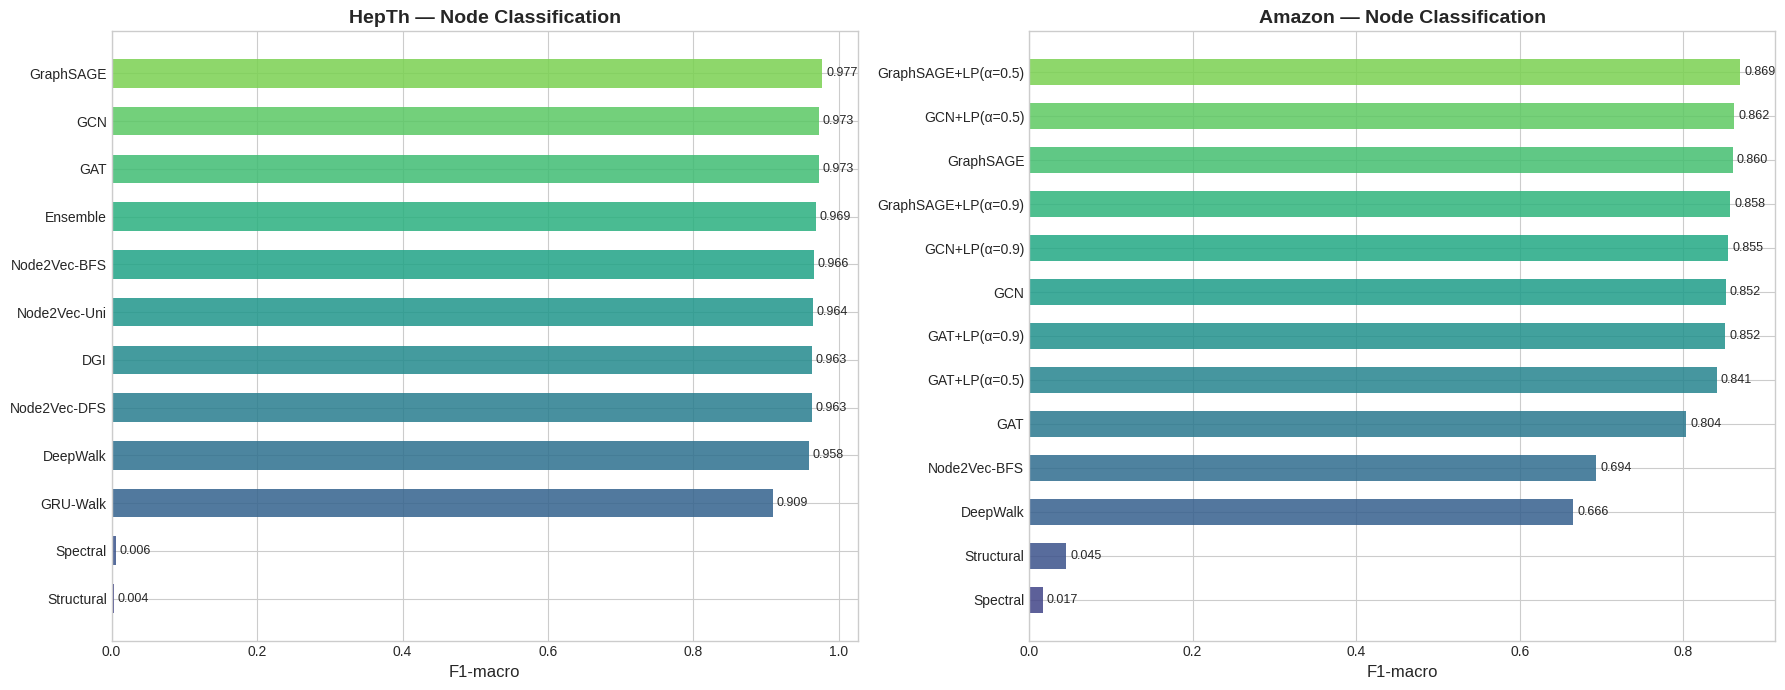

In [52]:
# ============================================================
# 12.2  Visualization — Node Classification comparison
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

for ax, df, title in [
    (axes[0], df_nc_hepth, "HepTh — Node Classification"),
    (axes[1], df_nc_amazon, "Amazon — Node Classification"),
]:
    if df.empty or 'accuracy' not in df.columns:
        ax.text(0.5, 0.5, "No results", ha='center')
        continue
    df_plot = df.sort_values('f1_macro', ascending=True)
    y_pos = np.arange(len(df_plot))
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(df_plot)))

    bars = ax.barh(y_pos, df_plot['f1_macro'], color=colors, alpha=0.85, height=0.6)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(df_plot['Method'], fontsize=10)
    ax.set_xlabel('F1-macro', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')

    for bar, val in zip(bars, df_plot['f1_macro']):
        ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
                f'{val:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('node_classification_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


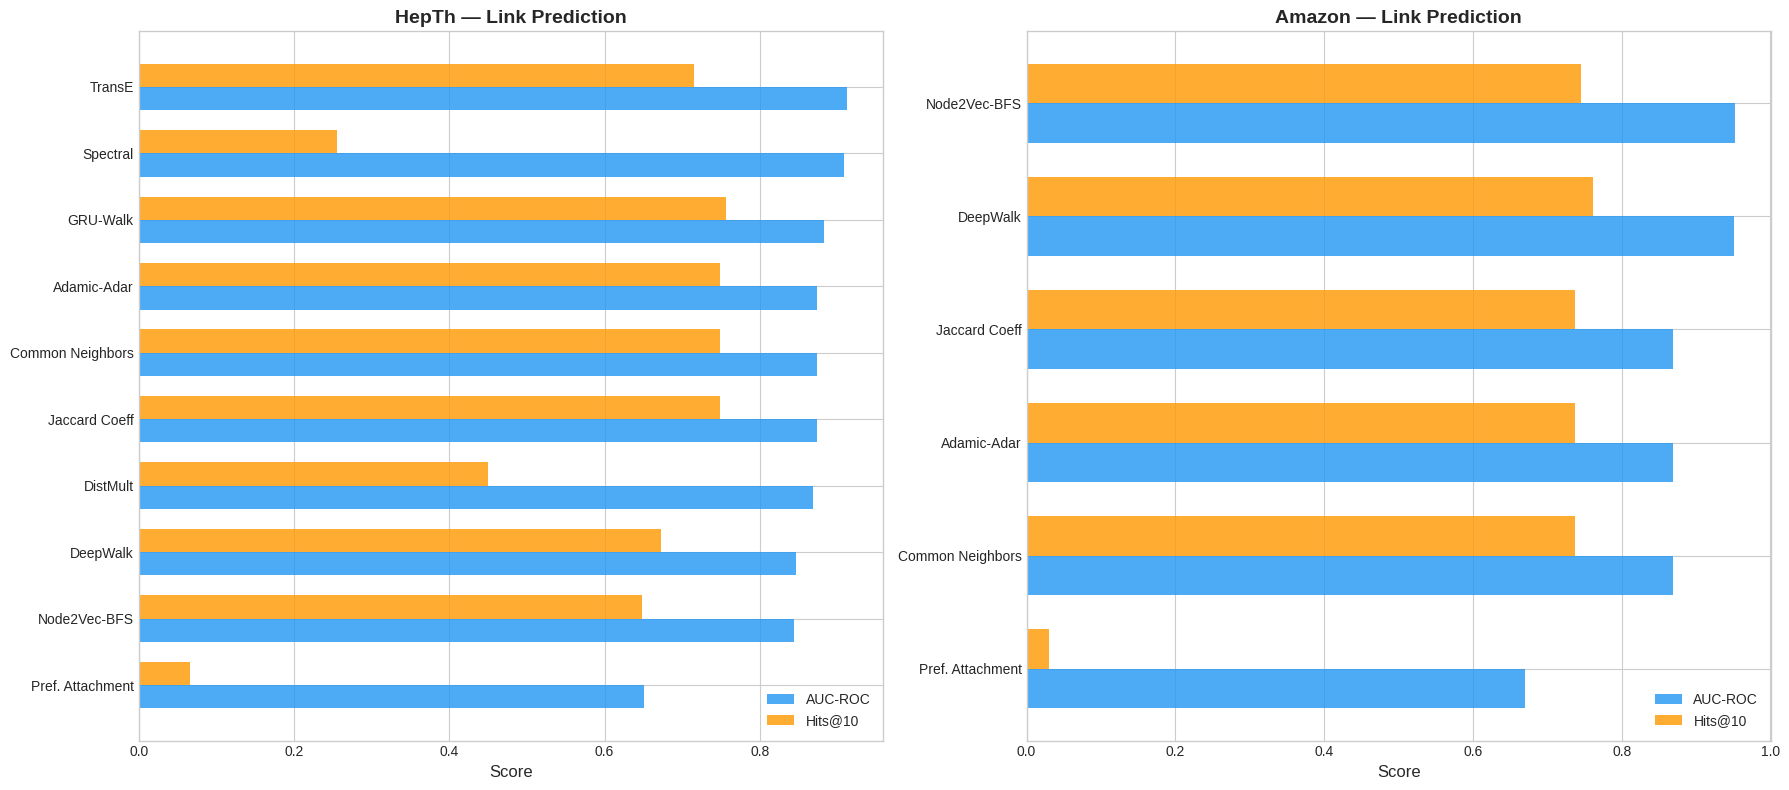

In [53]:
# ============================================================
# 12.3  Visualization — Link Prediction comparison
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

for ax, df, title in [
    (axes[0], df_lp_hepth, "HepTh — Link Prediction"),
    (axes[1], df_lp_amazon, "Amazon — Link Prediction"),
]:
    if df.empty or 'auc' not in df.columns:
        ax.text(0.5, 0.5, "No results", ha='center')
        continue
    df_plot = df.sort_values('auc', ascending=True)
    y_pos = np.arange(len(df_plot))

    # Plot AUC and Hits@10 side by side
    h = 0.35
    colors_auc = '#2196F3'
    colors_hits = '#FF9800'

    ax.barh(y_pos - h/2, df_plot['auc'], h, label='AUC-ROC', color=colors_auc, alpha=0.8)
    if 'hits@10' in df_plot.columns:
        ax.barh(y_pos + h/2, df_plot['hits@10'], h, label='Hits@10', color=colors_hits, alpha=0.8)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(df_plot['Method'], fontsize=10)
    ax.set_xlabel('Score', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig('link_prediction_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


---
# Part 13: Embedding Visualization (UMAP)


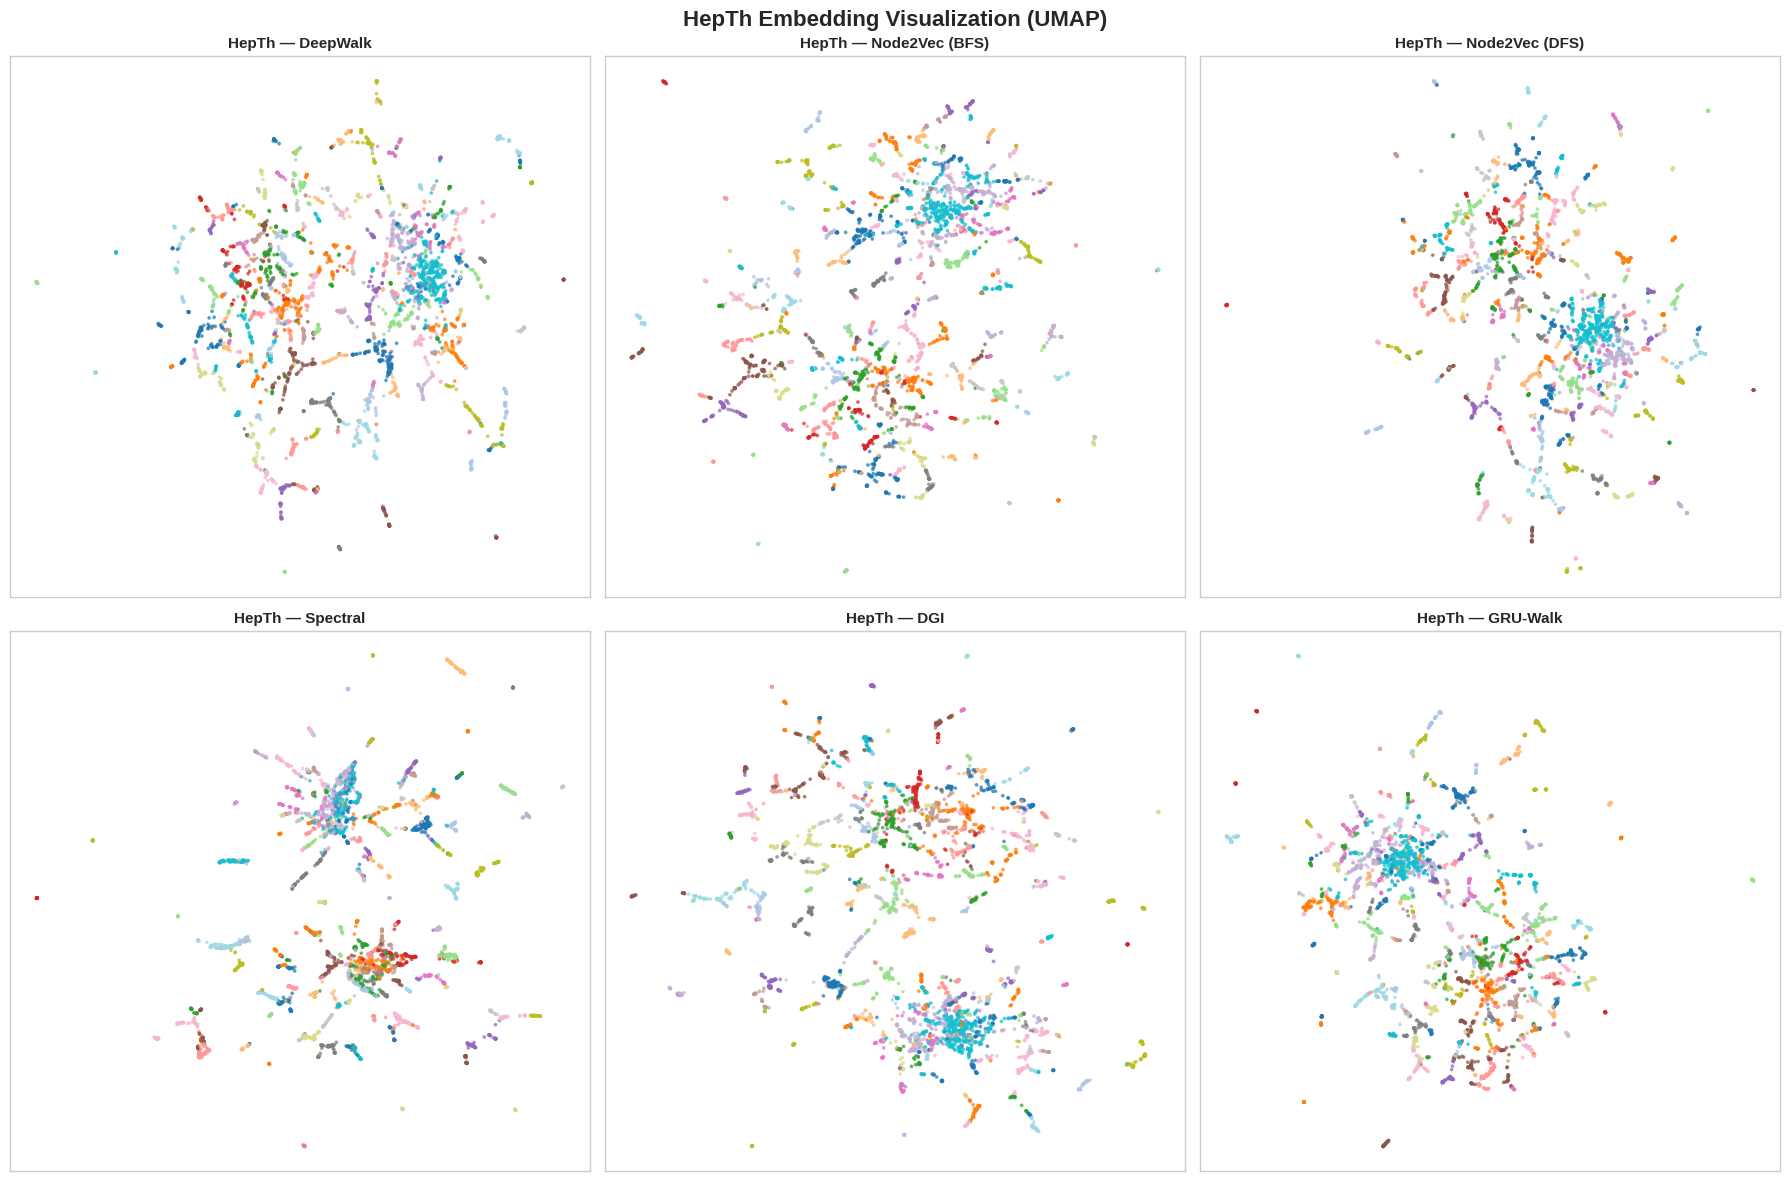

In [54]:
# ============================================================
# 13.1  UMAP Visualization
# ============================================================
def plot_embedding_umap(embeddings_dict, labeled_nodes, labels, title,
                        ax, max_points=5000, seed=42):
    """UMAP 2D projection colored by label."""
    valid = [(n, l) for n, l in zip(labeled_nodes, labels) if n in embeddings_dict]
    if not valid:
        ax.text(0.5, 0.5, "No valid nodes", ha='center')
        return

    if len(valid) > max_points:
        idx = np.random.choice(len(valid), max_points, replace=False)
        valid = [valid[i] for i in idx]

    nodes, labels_arr = zip(*valid)
    X = np.array([embeddings_dict[n] for n in nodes])
    y = np.array(labels_arr)

    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=seed)
    X_2d = reducer.fit_transform(X)

    scatter = ax.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='tab20',
                         s=3, alpha=0.6)
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xticks([])
    ax.set_yticks([])

# HepTh embeddings
emb_configs = [
    (hepth_dw_emb, "DeepWalk"),
    (hepth_n2v_bfs, "Node2Vec (BFS)"),
    (hepth_n2v_dfs, "Node2Vec (DFS)"),
    (hepth_spectral_emb, "Spectral"),
    (dgi_emb_dict, "DGI"),
    (gru_hepth_emb if 'gru_hepth_emb' in dir() else hepth_dw_emb,
     "GRU-Walk" if 'gru_hepth_emb' in dir() else "DeepWalk (dup)"),
]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
for ax, (emb, name) in zip(axes.flatten(), emb_configs):
    plot_embedding_umap(emb, labeled_nodes_hepth, encoded_labels_hepth,
                        f"HepTh — {name}", ax)

plt.suptitle("HepTh Embedding Visualization (UMAP)", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('hepth_embedding_umap.png', dpi=150, bbox_inches='tight')
plt.show()


---
# Part 14: GNN Training Curves


  ✓ Loaded: gnn_histories_hepth (from checkpoint)


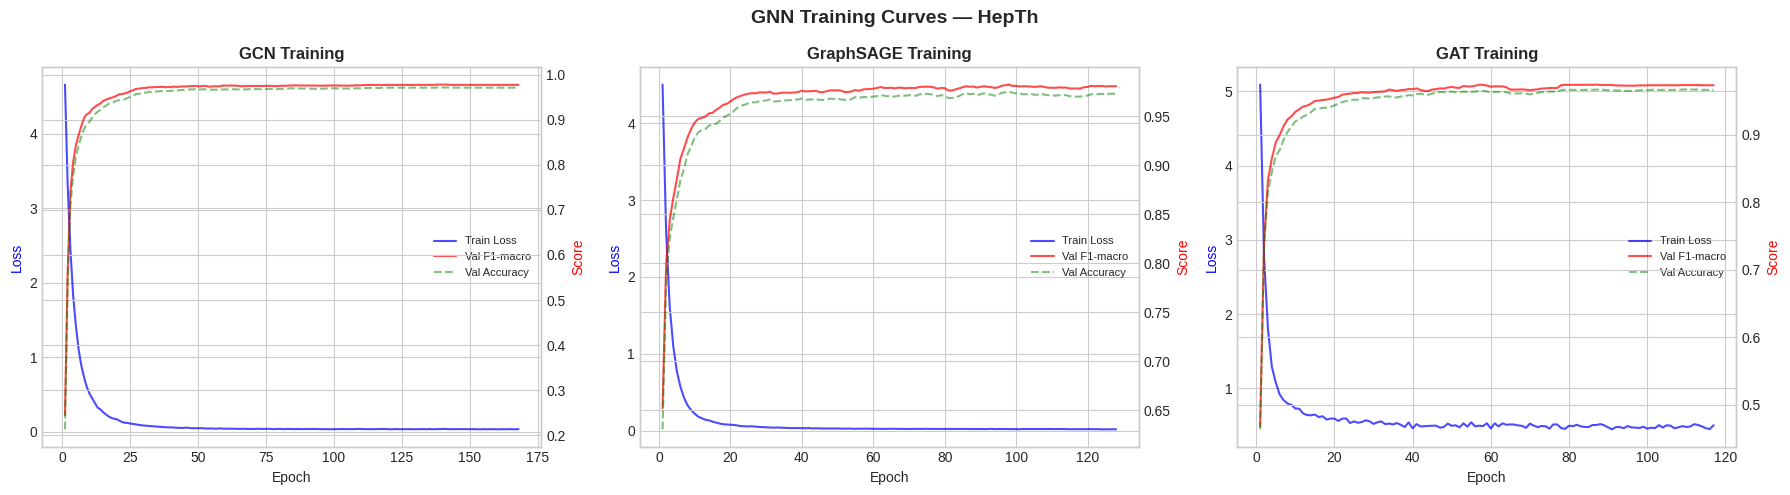

In [55]:
# ============================================================
# 14.1  Plot GNN training curves
# ============================================================
gnn_hist = ckpt.load('gnn_histories_hepth')
if gnn_hist is None:
    print("No GNN training histories saved. (Run Part 6 first.)")
else:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for ax, (name, hist) in zip(axes, gnn_hist.items()):
        ax2 = ax.twinx()

        ep = range(1, len(hist['train_loss']) + 1)
        l1, = ax.plot(ep, hist['train_loss'], 'b-', alpha=0.7, label='Train Loss')
        l2, = ax2.plot(ep, hist['val_f1'], 'r-', alpha=0.7, label='Val F1-macro')
        l3, = ax2.plot(ep, hist['val_acc'], 'g--', alpha=0.5, label='Val Accuracy')

        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss', color='blue')
        ax2.set_ylabel('Score', color='red')
        ax.set_title(f'{name} Training', fontweight='bold')
        ax.legend(handles=[l1, l2, l3], loc='center right', fontsize=8)

    plt.suptitle("GNN Training Curves — HepTh", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('gnn_training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()


---
# Part 15: Conclusion & Method Comparison

## Method Comparison Matrix

| Method | Supervised | Inductive | Scalable (>100K) | NC Quality | LP Quality |
|--------|-----------|-----------|------------------|------------|------------|
| Structural Features | ✗ | ✓ | ✓ | ★★☆ | ★☆☆ |
| DeepWalk | ✗ | ✗ | ✓ | ★★★ | ★★★ |
| Node2Vec | ✗ | ✗ | ✓ | ★★★ | ★★★ |
| Laplacian Eigenmaps | ✗ | ✗ | ✗ | ★★☆ | ★★☆ |
| GCN | ✓ | ✗ | ~(subgraph) | ★★★★ | ★★★ |
| GraphSAGE | ✓ | ✓ | ✓ (mini-batch) | ★★★★ | ★★★ |
| GAT | ✓ | ✗ | ✗ | ★★★★★ | ★★★ |
| **TransE** | ✗ | ✗ | ✓ | — | ★★★ |
| **DistMult** | ✗ | ✗ | ✓ | — | ★★★★ |
| **GRU Walk Encoder** | ✗ | ✗ | ~(memory) | ★★★ | ★★★ |
| **DGI (Self-supervised)** | ✗ | ✗ | ~(memory) | ★★★★ | — |
| **Ensemble** | ✗ | ✗ | ✗ | ★★★★★ | — |

## Key Insights

1. **Shallow embeddings** (DeepWalk, Node2Vec) remain competitive, especially for link prediction on large graphs
2. **GNNs** with supervision achieve the best node classification when labels are available
3. **TransE/DistMult** offer a fundamentally different embedding paradigm (translational vs. proximity); DistMult's bilinear scoring often outperforms TransE on symmetric relations
4. **GRU Walk Encoder** captures sequential patterns in walks that Word2Vec misses — particularly beneficial for graphs with complex local structure
5. **DGI** produces strong embeddings without any labels, making it ideal when supervision is scarce
6. **Ensemble fusion** consistently outperforms individual methods by combining complementary signals
7. **Rule-based baselines** (Adamic-Adar, Common Neighbors) are surprisingly strong for link prediction and should always be included
8. **Scale dictates method**: Amazon (335K nodes) requires Node2Vec/GraphSAGE; HepTh (6K) allows all methods

## Recommendations
- **Start with**: Node2Vec (fast, strong baseline for both tasks)
- **Large graphs**: GraphSAGE (mini-batch training, inductive)
- **Small graphs, max accuracy**: GAT or Ensemble
- **No labels**: DGI → downstream classifier
- **Link prediction**: Include rule-based baselines + TransE/DistMult


In [56]:
# ============================================================
# Final checkpoint status
# ============================================================
print("\n" + "=" * 70)
print("EXPERIMENT COMPLETE — Checkpoint Status")
print("=" * 70)
ckpt.status()



EXPERIMENT COMPLETE — Checkpoint Status
Checkpoint                                   Size  Time
---------------------------------------------------------------------------
  amazon_graph_data                        26.4MB  2026-02-17 04:55:00
  dgi_results_hepth                         5.8MB  2026-02-17 17:01:11
  gat_amazon                                0.3MB  2026-02-17 14:21:11
  gat_hepth                                 0.4MB  2026-02-17 14:17:38
  gcn_amazon                                0.2MB  2026-02-17 14:19:45
  gcn_hepth                                 0.2MB  2026-02-17 14:17:35
  gnn_histories_hepth                       0.0MB  2026-02-17 14:17:38
  gru_walk_embeddings                       5.8MB  2026-02-17 17:00:18
  hepth_graph_data                          1.1MB  2026-02-17 04:55:10
  kge_results_hepth                        11.6MB  2026-02-17 16:53:15
  lp_results_amazon                        20.5MB  2026-02-17 16:50:54
  lp_results_hepth                          0.